In [66]:
# Importing the libraries
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.timeseries import LombScargle

from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

import lightkurve as lk
from altaipony.flarelc import FlareLightCurve 

from uncertainties import *

%matplotlib inline 

In [67]:
# Plot settings
plt.rc("font", size=10)
plt.rcParams['font.family'] = 'Liberation Serif'

plt.close('all')

In [68]:
# Functions
def gaussian(x, a, mu, sigma):
    return a * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def sine_function(t, amplitude, frequency, phase):
    return amplitude * np.cos(2 * np.pi * frequency * t + phase)

def fit_sinusoid(phase, folded_flux):
    def sinusoid(phase, amplitude, phase_shift, offset):
        return amplitude * np.sin(2 * np.pi * phase + phase_shift) + offset

    # Initial guesses for amplitude, phase shift, and offset
    initial_guess = [np.ptp(folded_flux) / 2, 0, np.mean(folded_flux)]

    popt, _ = curve_fit(sinusoid, phase, folded_flux, p0=initial_guess)

    amplitude, phase_shift, offset = popt

    fitted_curve = sinusoid(phase, amplitude, phase_shift, offset)

    residuals = folded_flux - fitted_curve

    return fitted_curve, residuals

def phase_fold(time, flux, frequency):
    phase = (time * frequency) % 1
    sorted_indices = np.argsort(phase)
    return phase[sorted_indices], flux[sorted_indices]

def window_function(time, max_frequency):
    frequency, power = LombScargle(time, np.ones_like(time)).autopower(maximum_frequency=max_frequency)
    return frequency, power

def save_significant_frequencies_to_csv(significant_frequencies, file_name):
    formatted_data = []

    for freq in significant_frequencies:
        formatted_data.append({
            "frequency": f"{freq['frequency']:.5f}",
            "period": f"{freq['period']:.6f}",
            "amplitude": f"{freq['amplitude']:.2f}",
            "snr": f"{freq['snr']:.2f}",
            "fap": f"{freq['fap']:.2e}"
        })

    df = pd.DataFrame(formatted_data)
    df.to_csv(f'output/{file_name}.csv', index=False)

def prewhiten_lightcurve(file_path_or_name, time, flux, flux_model, max_frequencies=4, max_frequency=10, sigma_range=0.002):
    if isinstance(file_path_or_name, str):
        residual_flux = flux.copy() #- flux_model
    else:
        residual_flux = flux.copy()

    frequencies = []
    uncertainties = []
    snrs = []
    faps = []

    periodograms = []
    window_functions = []
    noise_levels = []

    phase_folded_data = []

    significant_frequencies = []
    for i in range(max_frequencies):
        # Compute the Lomb-Scargle periodogram
        ls = LombScargle(time, residual_flux)
        frequency, power = ls.autopower(maximum_frequency=max_frequency)

        periodograms.append((frequency, power))

        # Compute the window function
        window_frequency, window_power = window_function(time, max_frequency)
        window_functions.append((window_frequency, window_power))

        # Estimate the noise level (median of the power spectrum)
        noise_level = np.median(power)
        noise_levels.append(noise_level)

        # Find the peak frequency
        peaks, _ = find_peaks(power)
        peak_powers = power[peaks]
        peak_frequencies = frequency[peaks]
        best_peak_idx = np.argmax(peak_powers)

        initial_frequency = peak_frequencies[best_peak_idx]
        initial_power = peak_powers[best_peak_idx]

        # Fit a Gaussian around the peak for better precision
        peak_mask = (frequency > initial_frequency - sigma_range) & (frequency < initial_frequency + sigma_range)
        freq_to_fit = frequency[peak_mask]
        power_to_fit = power[peak_mask]

        try:
            popt, pcov = curve_fit(gaussian, freq_to_fit, power_to_fit, 
                                   p0=[initial_power, initial_frequency, sigma_range])
            power_fit, center, sigma = popt
            uncertainty = np.sqrt(np.diag(pcov))[1]  # Uncertainty in the center frequency
        except:
            # Fallback to Lomb-Scargle peak if Gaussian fit fails
            print(f"Gaussian fit failed at f = {initial_frequency:.5f}")
            center = initial_frequency
            power_fit = initial_power
            uncertainty = np.nan
            popt = [np.nan, np.nan, np.nan]

        # Compute SNR and FAP
        snr = power_fit / noise_level
        fap = ls.false_alarm_probability(power_fit)

        # Store the results
        frequencies.append(center)
        uncertainties.append(uncertainty)
        snrs.append(snr)
        faps.append(fap)

        # Phase fold the light curve and fit sinusoid
        phase, folded_flux = phase_fold(time, residual_flux, center)
        phase_fit, residuals = fit_sinusoid(phase, folded_flux)
        phase_folded_data.append((phase, folded_flux, phase_fit, residuals))

        # Prewhiten the light curve
        phase = 2 * np.pi * center * time
        sin_fit = np.column_stack([np.sin(phase), np.cos(phase)])
        coeff, _, _, _ = np.linalg.lstsq(sin_fit, residual_flux, rcond=None)
        residual_flux -= coeff[0] * np.sin(phase) + coeff[1] * np.cos(phase)

        significant_frequencies.append({
            "frequency": ufloat(center, uncertainty),
            "period": 1 / ufloat(center, uncertainty),
            "amplitude": np.sqrt(power_fit),
            "snr": snr,
            "fap": fap,
            "gaussian_params": popt
        })

    print("\nSignificant Frequencies:")
    for freq in significant_frequencies:
        print(f"Frequency: {freq['frequency']:.5f} c/d, Period: {freq['period']:.6f} d, Amplitude: {freq['amplitude']:.5f}, SNR: {freq['snr']:.2f}, FAP: {freq['fap']:.2e}")

    # Plotting the lightcurve
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_xlabel('Time (days)')
    ax.yaxis.label.set_fontsize(20)
    ax.set_ylabel('Flux')
    ax.xaxis.label.set_fontsize(20)
    ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
    ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
    
    ax.scatter(time, flux, color='blue', s=0.4, label='Non de-trended')

    # ax.scatter(time, flux - flux_model + np.mean(flux), color='green', s=0.4, label='De-trended')
    # ax.plot(time, flux_model, color='red', label='Savitzky-Golay Model')

    # ax.legend(fontsize=15)

    plt.tight_layout()
    plt.savefig(f'images/lc/{file_path_or_name}_lc.png', bbox_inches='tight')
    plt.show()
    
    # Create a combined plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)
    axes = axes.flatten()

    for i, (ax, (frequency, power), (window_frequency, window_power), freq, noise_level) in enumerate(zip(axes, periodograms, window_functions, frequencies, noise_levels)):
        ax.set_xlabel('Frequency (cycles/day)')
        ax.yaxis.label.set_fontsize(20)
        ax.set_ylabel('Amplitude')
        ax.xaxis.label.set_fontsize(20)
        ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
        ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
        ax.set_ylim(0, np.max(np.sqrt(power))+0.1) 

        if isinstance(file_path_or_name, str):
            # ax.set_xlim(freq - 0.005, freq + 0.005)
            ax.set_xscale('log')
        # else: 
            # ax.set_xlim(freq - 0.05, freq + 0.05)

        ax.plot(frequency, np.sqrt(power), label="Periodogram")
        # ax.scatter(frequency, np.sqrt(power))

        ax.plot(window_frequency, np.sqrt(window_power), label="Window Function", color='red', alpha=0.5)

        ax.axvline(freq, color="red", linestyle="--", label=f"f: {freq:.5f}, P: {1/freq:.6f}")

        ax.axhline(np.sqrt(noise_level), color='red', linestyle='-', label=f"Noise Level = {np.sqrt(noise_level):.2g}")

        # Plot Gaussian fit around the peak
        peak_mask = (frequency > freq - sigma_range) & (frequency < freq + sigma_range)
        freq_to_fit = frequency[peak_mask]
        power_to_fit = power[peak_mask]
        gaussian_fit = gaussian(freq_to_fit, *significant_frequencies[i]['gaussian_params'])
        ax.plot(freq_to_fit, np.sqrt(gaussian_fit), color="green")
        
        ax.legend(fontsize=15)

    plt.tight_layout()
    plt.savefig(f'images/period/{file_path_or_name}_per.png', bbox_inches='tight')
    # plt.show()

    # Create plots for sinusoidal fits
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    for i, (phase, folded_flux, phase_fit, residuals) in enumerate(phase_folded_data):
        if i >= 4:  # Limit to 4 subplots
            break

        ax_main = axs[i // 2, i % 2]
        ax_lightcurve = ax_main.inset_axes([0, 0.4, 1, 0.6], transform=ax_main.transAxes)
        ax_residuals = ax_main.inset_axes([0, 0, 1, 0.4], transform=ax_main.transAxes)

        ax_main.axis("off")

        ax_lightcurve.set_ylabel("Flux")
        ax_lightcurve.yaxis.label.set_fontsize(15)
        ax_lightcurve.set_title(f"Sinusoid Fit (f={frequencies[i]:.5f} c/d), P={1/frequencies[i]:.6f} d")
        ax_lightcurve.tick_params(axis="x", labelbottom=False)
        ax_lightcurve.tick_params(axis="both", which="major", length=8, width=0.5, labelsize=10)
        ax_lightcurve.tick_params(axis="both", which="minor", length=4, width=0.5, labelsize=8)

        ax_lightcurve.scatter(phase, folded_flux, s=1, color="blue", label="Lightcurve")
        ax_lightcurve.plot(phase, phase_fit, color="red", linewidth=2, label="Fit")

        ax_lightcurve.legend(loc="upper right", fontsize=10)

        ax_residuals.set_xlabel("Phase")
        ax_residuals.xaxis.label.set_fontsize(15)
        ax_residuals.set_ylabel("Residuals")
        ax_residuals.yaxis.label.set_fontsize(15)
        ax_residuals.tick_params(axis="both", which="major", length=8, width=0.5, labelsize=10)
        ax_residuals.tick_params(axis="both", which="minor", length=4, width=0.5, labelsize=8)

        ax_residuals.scatter(phase, residuals, s=1, color="blue")
        ax_residuals.axhline(0, color="black", linestyle="--")

    plt.tight_layout()
    plt.savefig(f'images/phase/{file_path_or_name}_phase_folded.png', bbox_inches='tight')
    plt.show()
    
    save_significant_frequencies_to_csv(significant_frequencies, file_path_or_name)

    return significant_frequencies

def analyze_light_curve(file_path_or_name, max_frequencies=4, max_frequency=10):
    # Load the light curve
    if isinstance(file_path_or_name, str):
        search_result = lk.search_lightcurve(file_path_or_name, author="Kepler", cadence="long")
        print(search_result)

        lc_collection = search_result.download_all()
        lc_collection_selected = lc_collection
        lc_stitched = lc_collection_selected.stitch()

        # pg = lc_stitched.to_periodogram()
        # pg.plot(scale='log')

        # period = pg.period_at_max_power
        # print(f"\nPeriod at max power: {period}")

        # lc_stitched.fold(period/2).scatter(label=f'Period = {period.value:.3f} d');

        time = lc_stitched.time.value
        flux = lc_stitched.flux

        # Sort time and flux by time
        sorted_indices = np.argsort(time)
        time = time[sorted_indices]
        flux = flux[sorted_indices]

        # Detrend the light curve using Savitzky-Golay filter
        flux_model = savgol_filter(flux, window_length=101, polyorder=2)

        # Remove NaN values if any
        mask = ~np.isnan(time) & ~np.isnan(flux) & ~np.isnan(flux_model)
        time = time[mask]
        flux = flux[mask]
        flux_model = flux_model[mask]

        # Save time and flux to CSV
        df_lightcurve = pd.DataFrame({'time': time, 'flux': flux, 'flux_model': flux_model})
        df_lightcurve.to_csv(f'output/{file_path_or_name}_lightcurve.csv', index=False)

        time = df_lightcurve['time'].values
        flux = df_lightcurve['flux'].values
        flux_model = df_lightcurve['flux_model'].values

        print(f'\nObservation time: {(time[-1]- time[0]):.2f} days')

        sigma_range = 0.001
    else:
        data = pd.read_csv(f'data/{file_path_or_name}.dat', sep=r'\s+', header=None, names=["time", "flux"])
        time = data["time"].values
        flux = data["flux"].values
        flux_model = None

        sigma_range = 0.003

    significant_frequencies = prewhiten_lightcurve(file_path_or_name, time, flux, flux_model, max_frequencies=max_frequencies, max_frequency=max_frequency, sigma_range=sigma_range)

    # Phase folding and visualization
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    for i, freq in enumerate(significant_frequencies):
        if i >= 4:  # Limit to 4 subplots
            break

        phase, folded_flux = phase_fold(time, flux, freq["frequency"].n)
        phase_fit, phase_residuals= fit_sinusoid(phase, folded_flux)

        # Create a grid of 2x2 plots with custom height ratios for lightcurve and residuals
        ax_main = axs[i // 2, i % 2]
        ax_lightcurve = ax_main.inset_axes([0, 0.4, 1, 0.6], transform=ax_main.transAxes)
        ax_residuals = ax_main.inset_axes([0, 0, 1, 0.4], transform=ax_main.transAxes)

        # Disable ticks and spines for the main axis to avoid extra ticks
        ax_main.axis("off")

        ax_lightcurve.set_ylabel("Flux")
        ax_lightcurve.yaxis.label.set_fontsize(15)
        ax_lightcurve.set_title(f"Sinusoid Fit (f={freq['frequency'].n:.5f} c/d, P={freq['period'].n:.6f} d)")
        ax_lightcurve.tick_params(axis="x", labelbottom=False) 
        ax_lightcurve.tick_params(axis="both", which="major", length=8, width=0.5, labelsize=10)
        ax_lightcurve.tick_params(axis="both", which="minor", length=4, width=0.5, labelsize=8)

        ax_lightcurve.scatter(phase, folded_flux, s=1, color="blue", label="Lightcurve")
        ax_lightcurve.plot(phase, phase_fit, color="red", linewidth=2, label="Fit")

        ax_lightcurve.legend(loc="upper right", fontsize=10)

        ax_residuals.set_xlabel("Phase")
        ax_residuals.xaxis.label.set_fontsize(15)
        ax_residuals.set_ylabel("Residuals")
        ax_residuals.yaxis.label.set_fontsize(15)
        ax_residuals.tick_params(axis="both", which="major", length=8, width=0.5, labelsize=10)
        ax_residuals.tick_params(axis="both", which="minor", length=4, width=0.5, labelsize=8)

        ax_residuals.scatter(phase, phase_residuals, s=1, color="blue")
        ax_residuals.axhline(0, color="black", linestyle="--")

    plt.tight_layout()
    plt.savefig(f'images/phase/{file_path_or_name}_phase_folded_orig.png', bbox_inches='tight')
    plt.show()

    return significant_frequencies

1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (3/476) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


SearchResult containing 18 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 00 2009 Kepler    1800 kplr002985767      0.0
  1 Kepler Quarter 01 2009 Kepler    1800 kplr002985767      0.0
  2 Kepler Quarter 02 2009 Kepler    1800 kplr002985767      0.0
  3 Kepler Quarter 03 2009 Kepler    1800 kplr002985767      0.0
  4 Kepler Quarter 04 2010 Kepler    1800 kplr002985767      0.0
  5 Kepler Quarter 05 2010 Kepler    1800 kplr002985767      0.0
  6 Kepler Quarter 06 2010 Kepler    1800 kplr002985767      0.0
  7 Kepler Quarter 07 2010 Kepler    1800 kplr002985767      0.0
  8 Kepler Quarter 10 2011 Kepler    1800 kplr002985767      0.0
  9 Kepler Quarter 08 2011 Kepler    1800 kplr002985767      0.0
 10 Kepler Quarter 09 2011 Kepler    1800 kplr002985767      0.0
 11 Kepler Quarter 11 2012 Kepler    1800 kplr0

3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (43/4159) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (43/4159) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (46/4538) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (46/4538) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (37/4313) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (37/4313) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (66/4295) of the cadences will be i


Observation time: 1470.46 days


/home/shep0r7/.local/lib/python3.12/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:251: RuntimeWarning: invalid value encountered in scalar power
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)



Significant Frequencies:
Frequency: 0.03670+/-0.00002 c/d, Period: 27.246804+/-0.014209 d, Amplitude: 0.20133, SNR: 7475.12, FAP: 0.00e+00
Frequency: 0.03671+/-0.00000 c/d, Period: 27.244037+/-0.003675 d, Amplitude: 1.00945, SNR: 1667990.01, FAP: nan
Frequency: 0.03671+/-0.00000 c/d, Period: 27.244195+/-0.003673 d, Amplitude: 1.00938, SNR: 1663040.36, FAP: nan
Frequency: 0.03671+/-0.00000 c/d, Period: 27.244185+/-0.003673 d, Amplitude: 1.00939, SNR: 1663860.66, FAP: nan


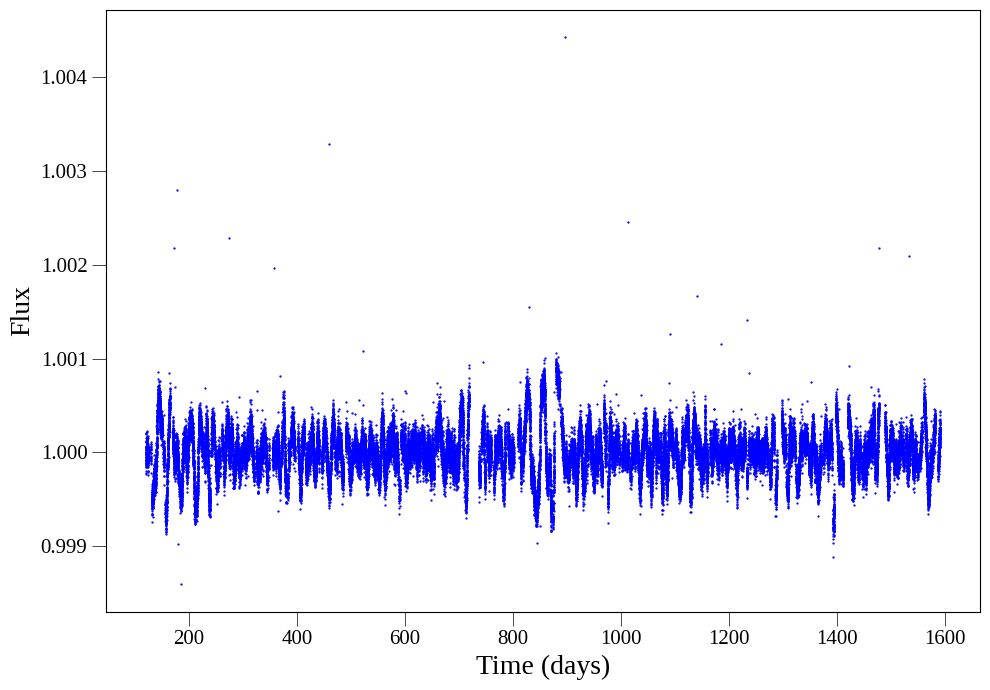

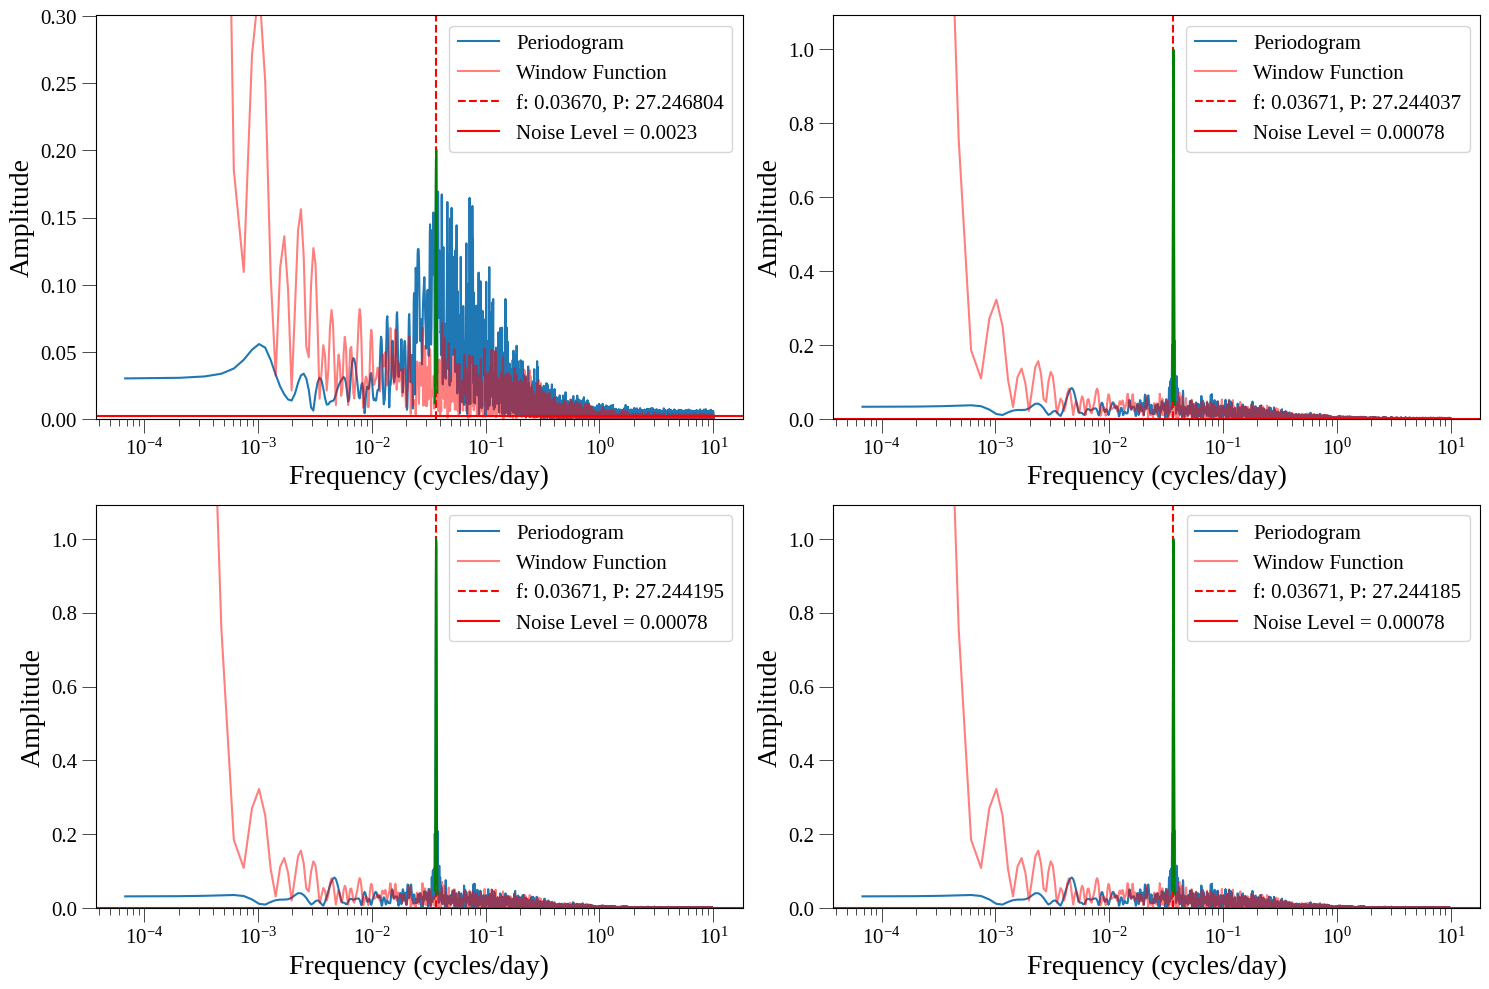

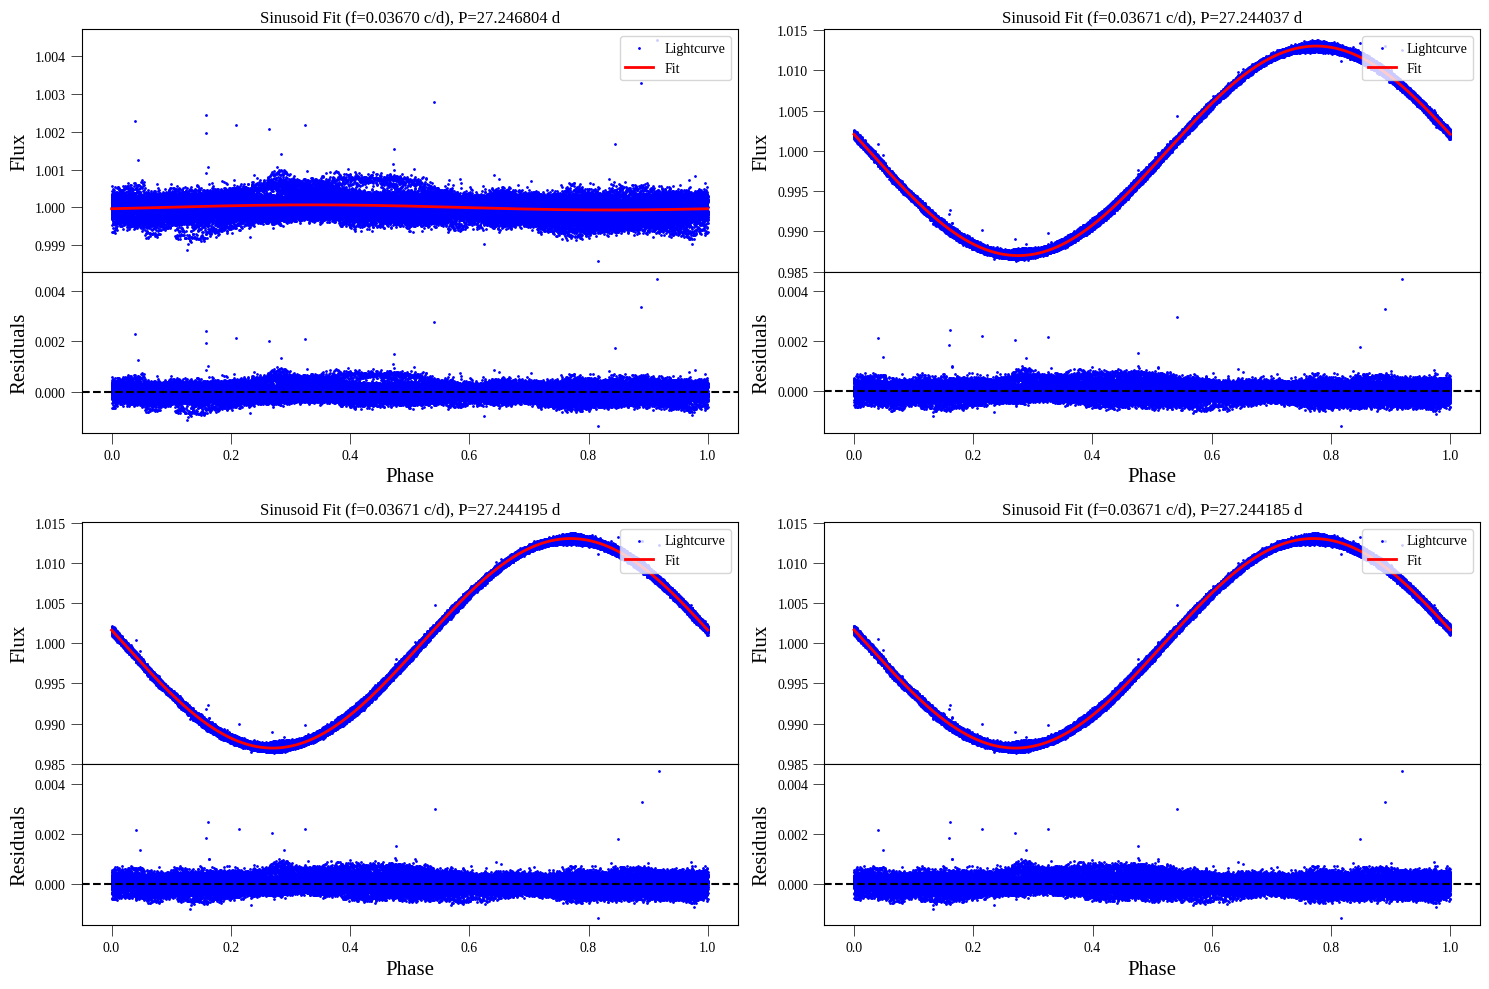

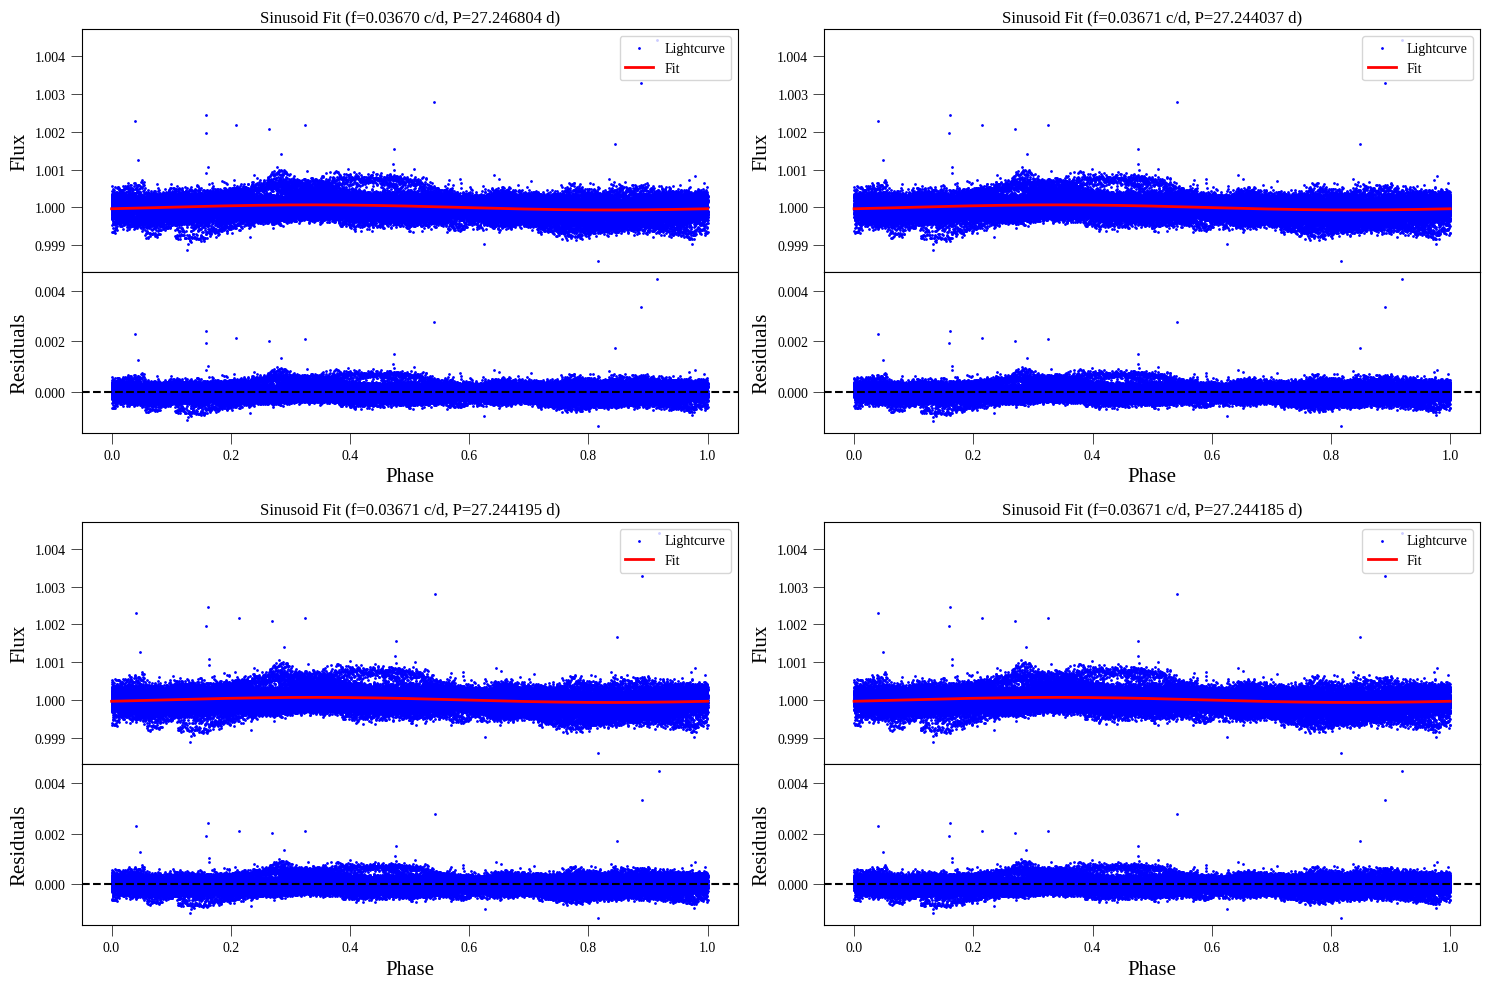

In [69]:
# Periodogram for Kepler-22b
freq_kepler22 = analyze_light_curve('Kepler-1063', max_frequencies=4, max_frequency=10)


Significant Frequencies:
Frequency: 4.96799+/-0.00003 c/d, Period: 0.201289+/-0.000001 d, Amplitude: 0.69113, SNR: 95.13, FAP: 1.77e-164
Frequency: 4.73131+/-0.00001 c/d, Period: 0.211358+/-0.000001 d, Amplitude: 0.67929, SNR: 95.83, FAP: 1.50e-156
Frequency: 1.10394+/-0.00002 c/d, Period: 0.905844+/-0.000012 d, Amplitude: 0.86399, SNR: 373.26, FAP: 0.00e+00
Frequency: 4.96742+/-0.00002 c/d, Period: 0.201312+/-0.000001 d, Amplitude: 0.17812, SNR: 24.60, FAP: 6.48e-05


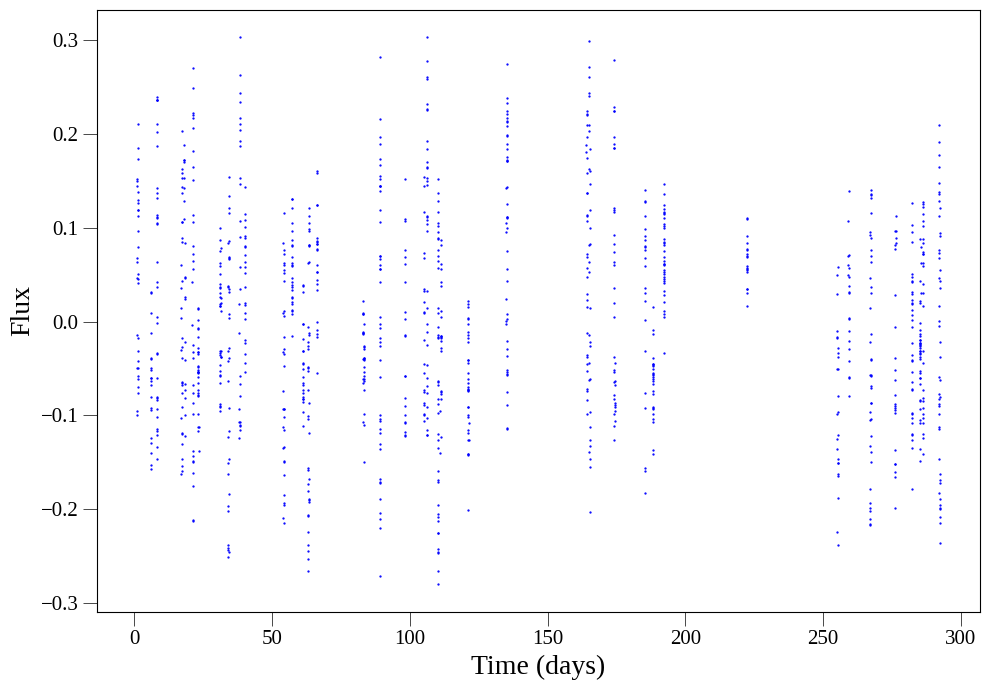

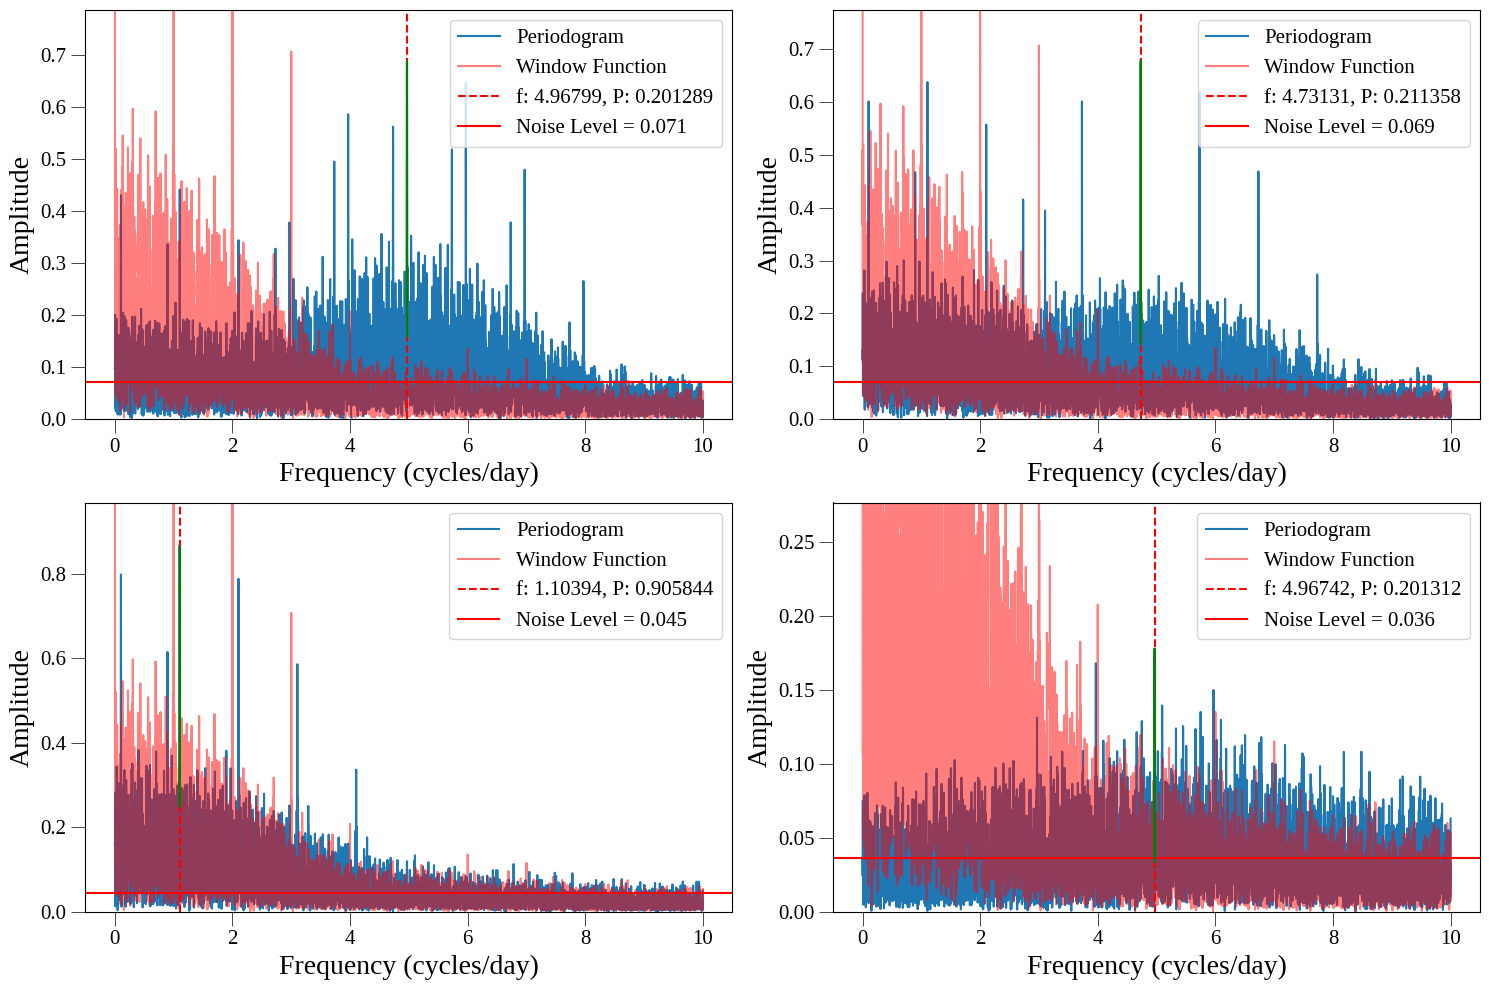

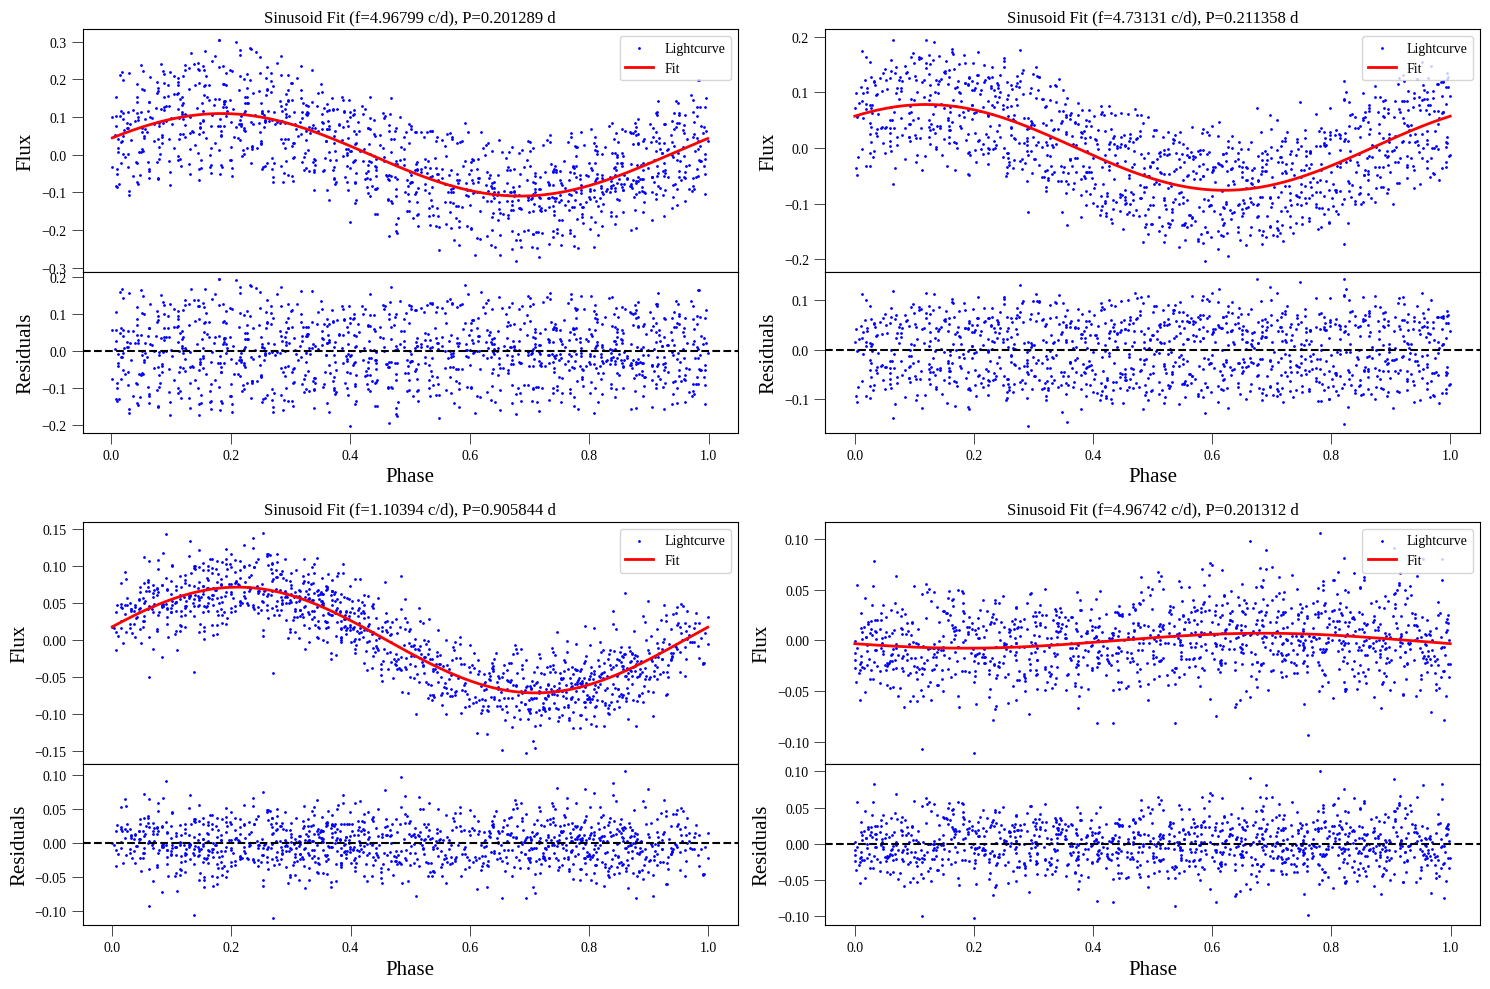

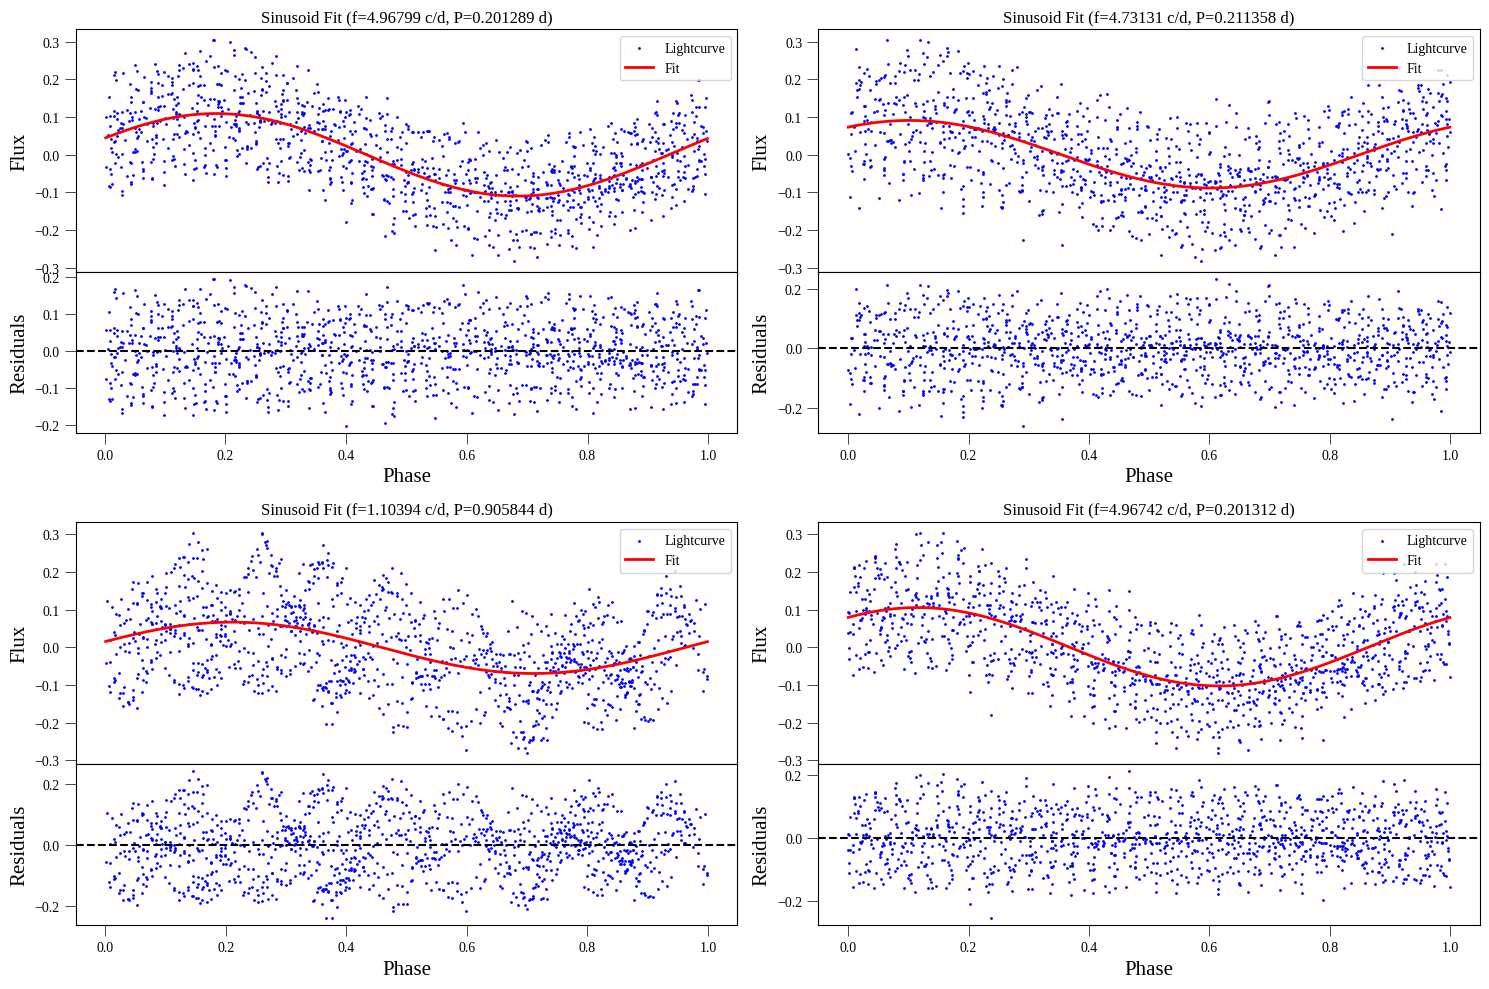

In [70]:
# # Periodogram for 1.dat
freq_1 = analyze_light_curve(1, max_frequencies=4, max_frequency=10)


Significant Frequencies:
Frequency: 3.04011+/-0.00003 c/d, Period: 0.328936+/-0.000003 d, Amplitude: 0.56267, SNR: 116.35, FAP: 7.90e-95
Frequency: 0.89276+/-0.00007 c/d, Period: 1.120118+/-0.000093 d, Amplitude: 0.53040, SNR: 128.85, FAP: 8.49e-82
Frequency: 1.91776+/-0.00001 c/d, Period: 0.521441+/-0.000003 d, Amplitude: 0.55376, SNR: 139.23, FAP: 4.34e-91
Frequency: 3.04152+/-0.00003 c/d, Period: 0.328783+/-0.000003 d, Amplitude: 0.16321, SNR: 18.02, FAP: 1.36e-03


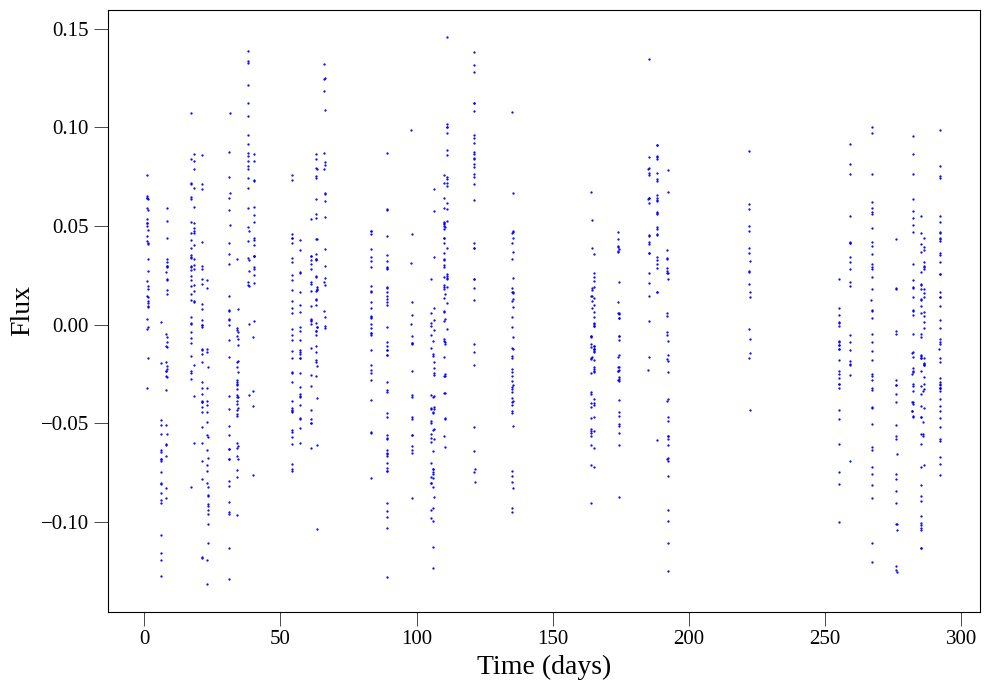

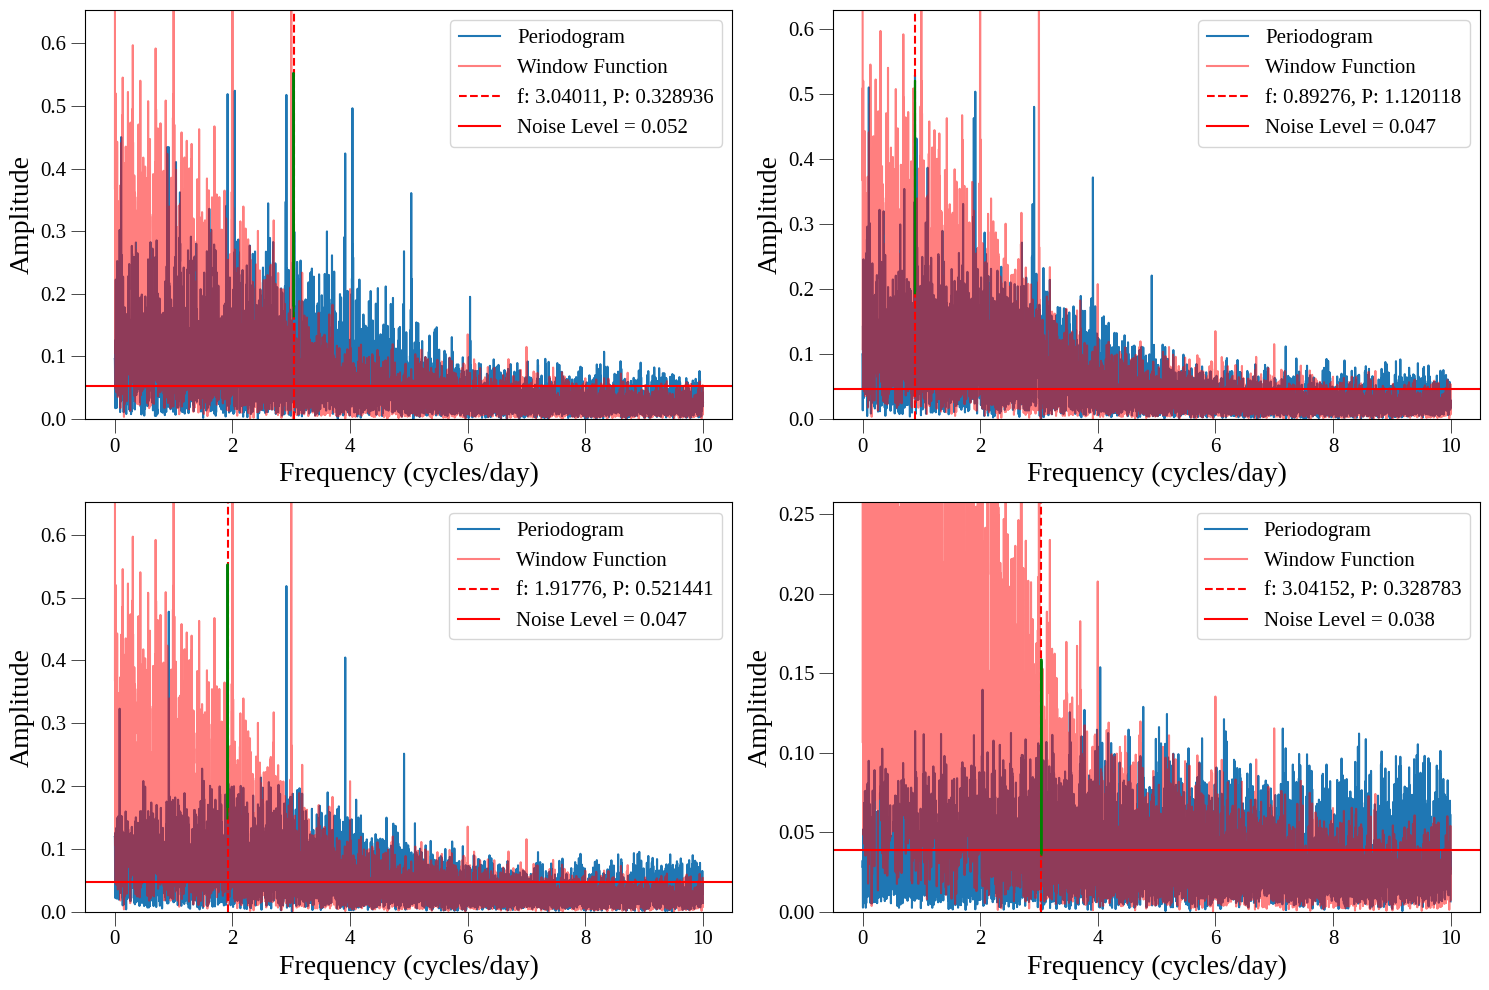

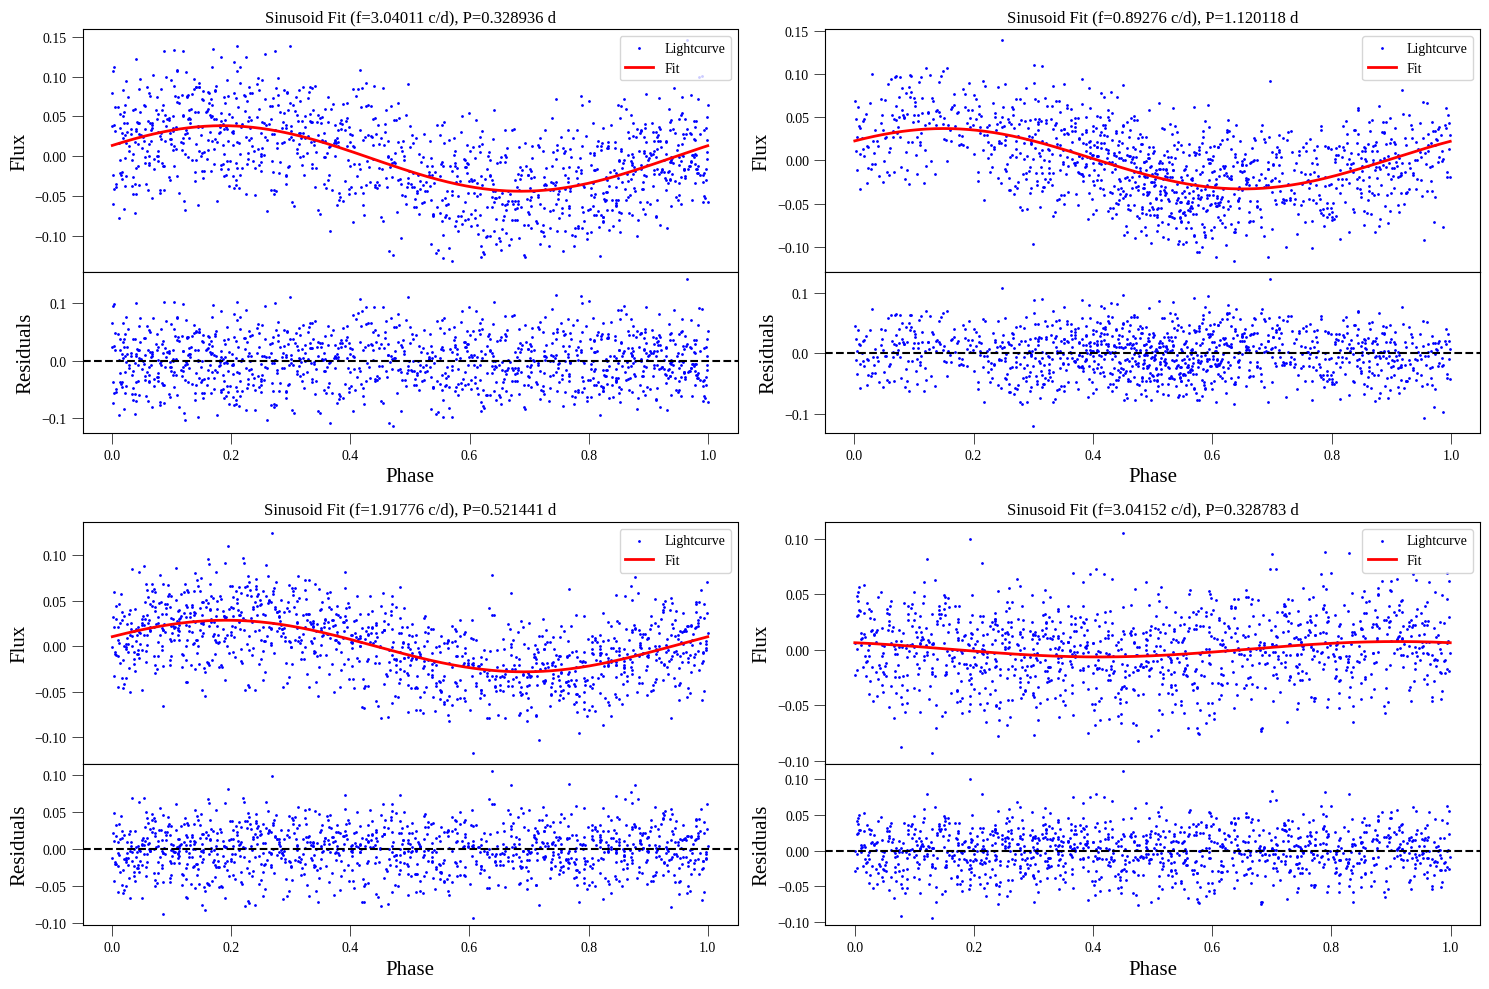

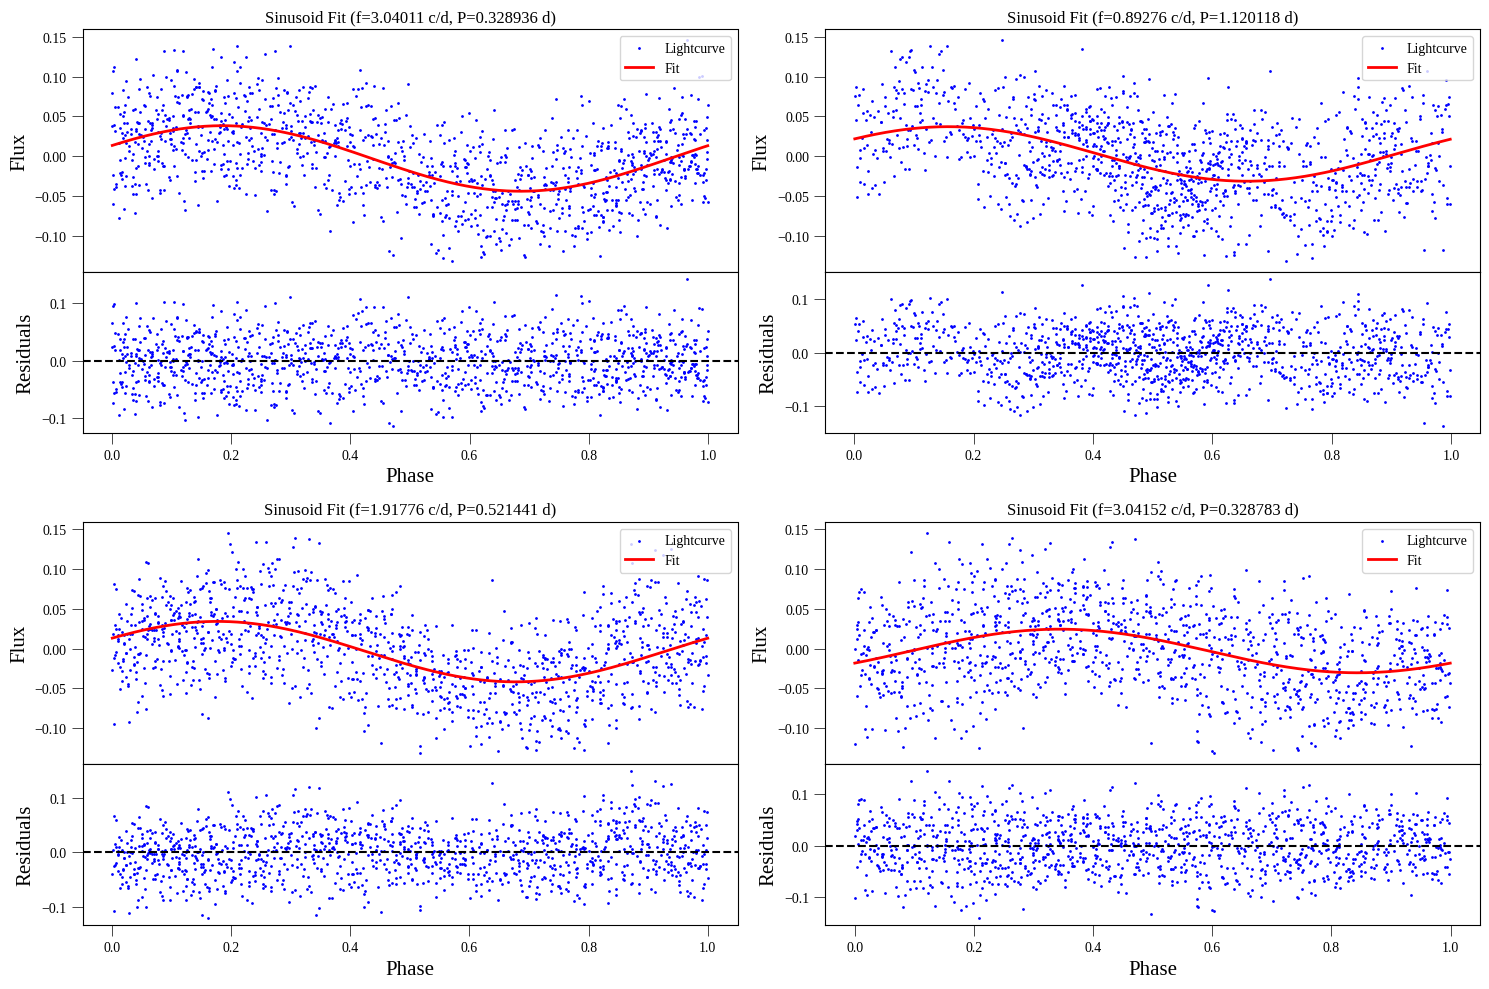

In [71]:
# # Periodogram for 2.dat
freq_2 = analyze_light_curve(2, max_frequencies=4, max_frequency=10)


Significant Frequencies:
Frequency: 2.35215+/-0.00002 c/d, Period: 0.425143+/-0.000004 d, Amplitude: 0.71611, SNR: 143.00, FAP: 1.51e-182
Frequency: 3.50067+/-0.00001 c/d, Period: 0.285659+/-0.000001 d, Amplitude: 0.80903, SNR: 205.34, FAP: 1.10e-271
Frequency: 2.92004+/-0.00003 c/d, Period: 0.342461+/-0.000004 d, Amplitude: 0.13462, SNR: 13.78, FAP: 1.85e-01
Frequency: 1.44576+/-0.00005 c/d, Period: 0.691679+/-0.000026 d, Amplitude: 0.10809, SNR: 9.45, FAP: 1.00e+00


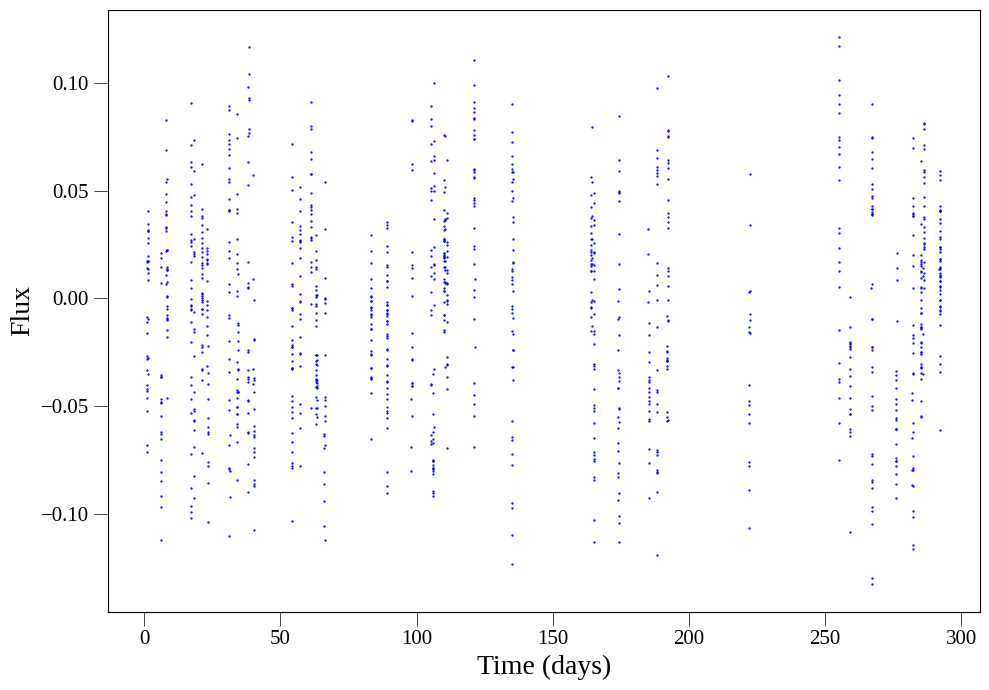

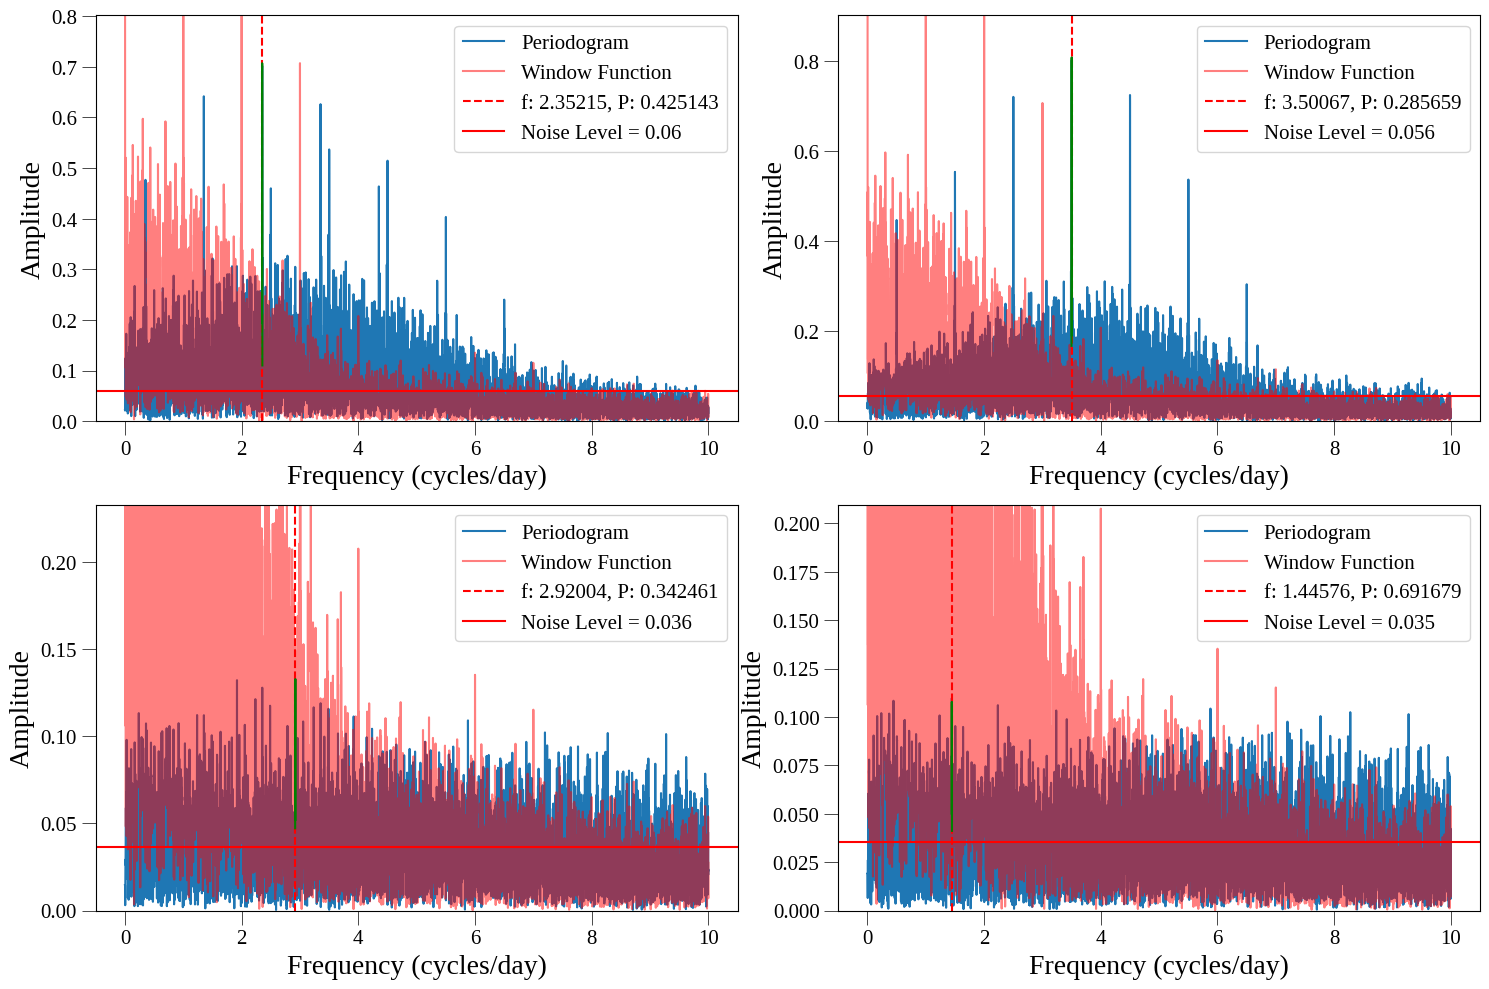

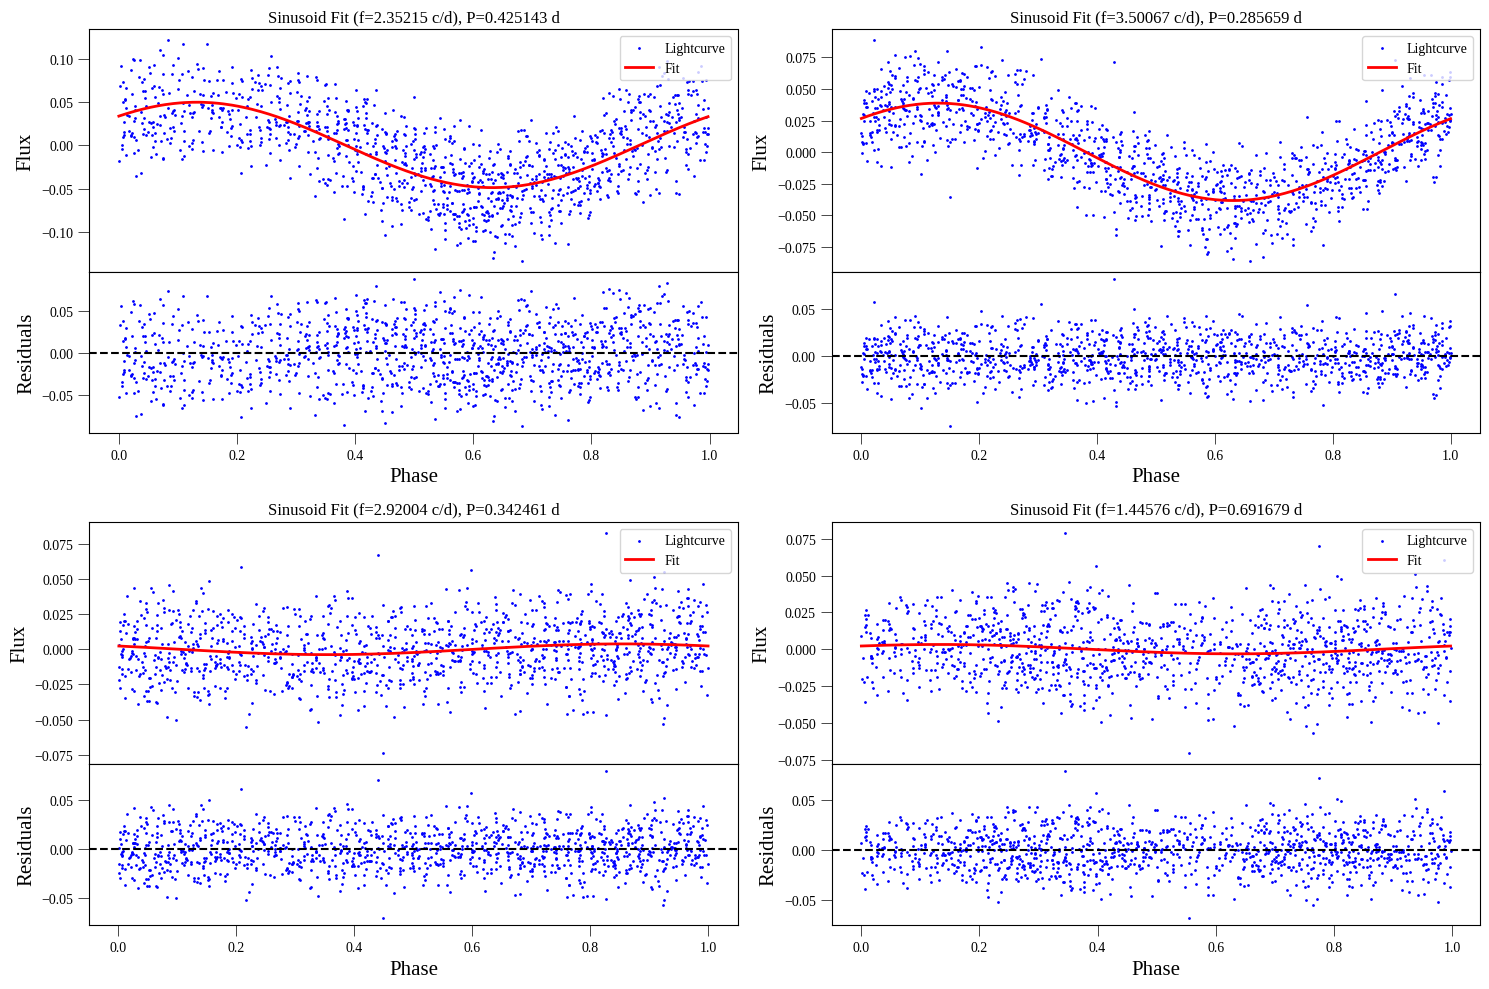

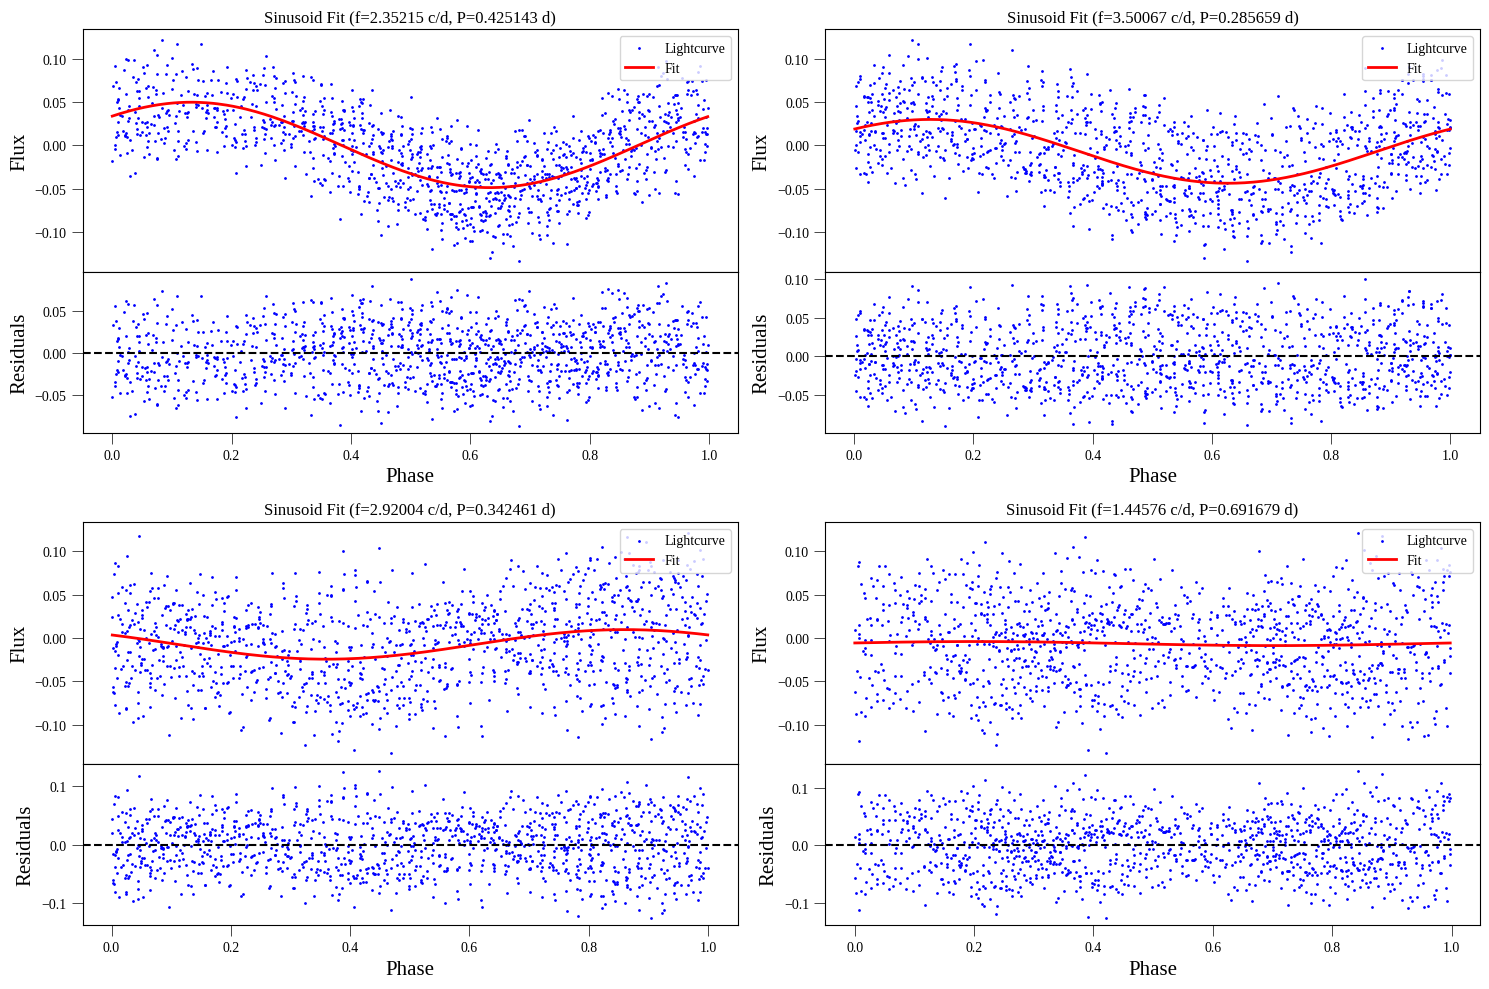

In [72]:
# # Periodogram for 3.dat
freq_3 = analyze_light_curve(3, max_frequencies=4, max_frequency=10)


Significant Frequencies:
Frequency: 1.83302+/-0.00002 c/d, Period: 0.545547+/-0.000006 d, Amplitude: 0.68218, SNR: 125.84, FAP: 1.88e-158
Frequency: 3.92680+/-0.00002 c/d, Period: 0.254660+/-0.000001 d, Amplitude: 0.78236, SNR: 192.19, FAP: 1.23e-241
Frequency: 6.04377+/-0.00004 c/d, Period: 0.165460+/-0.000001 d, Amplitude: 0.11587, SNR: 13.15, FAP: 9.53e-01
Frequency: 0.74150+/-0.00002 c/d, Period: 1.348620+/-0.000028 d, Amplitude: 0.10435, SNR: 11.71, FAP: 1.00e+00


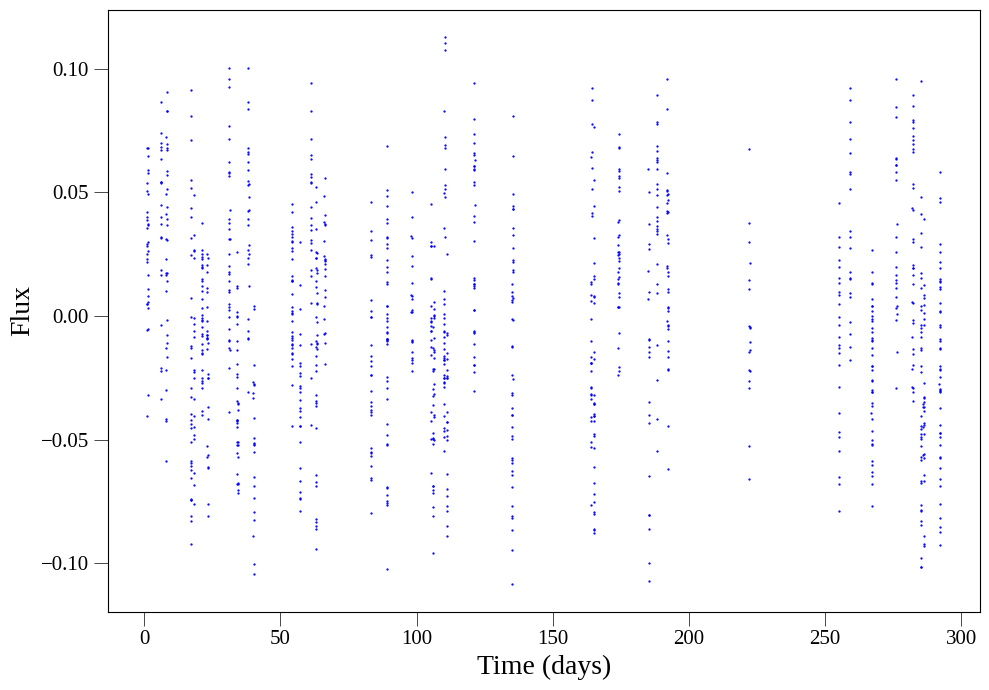

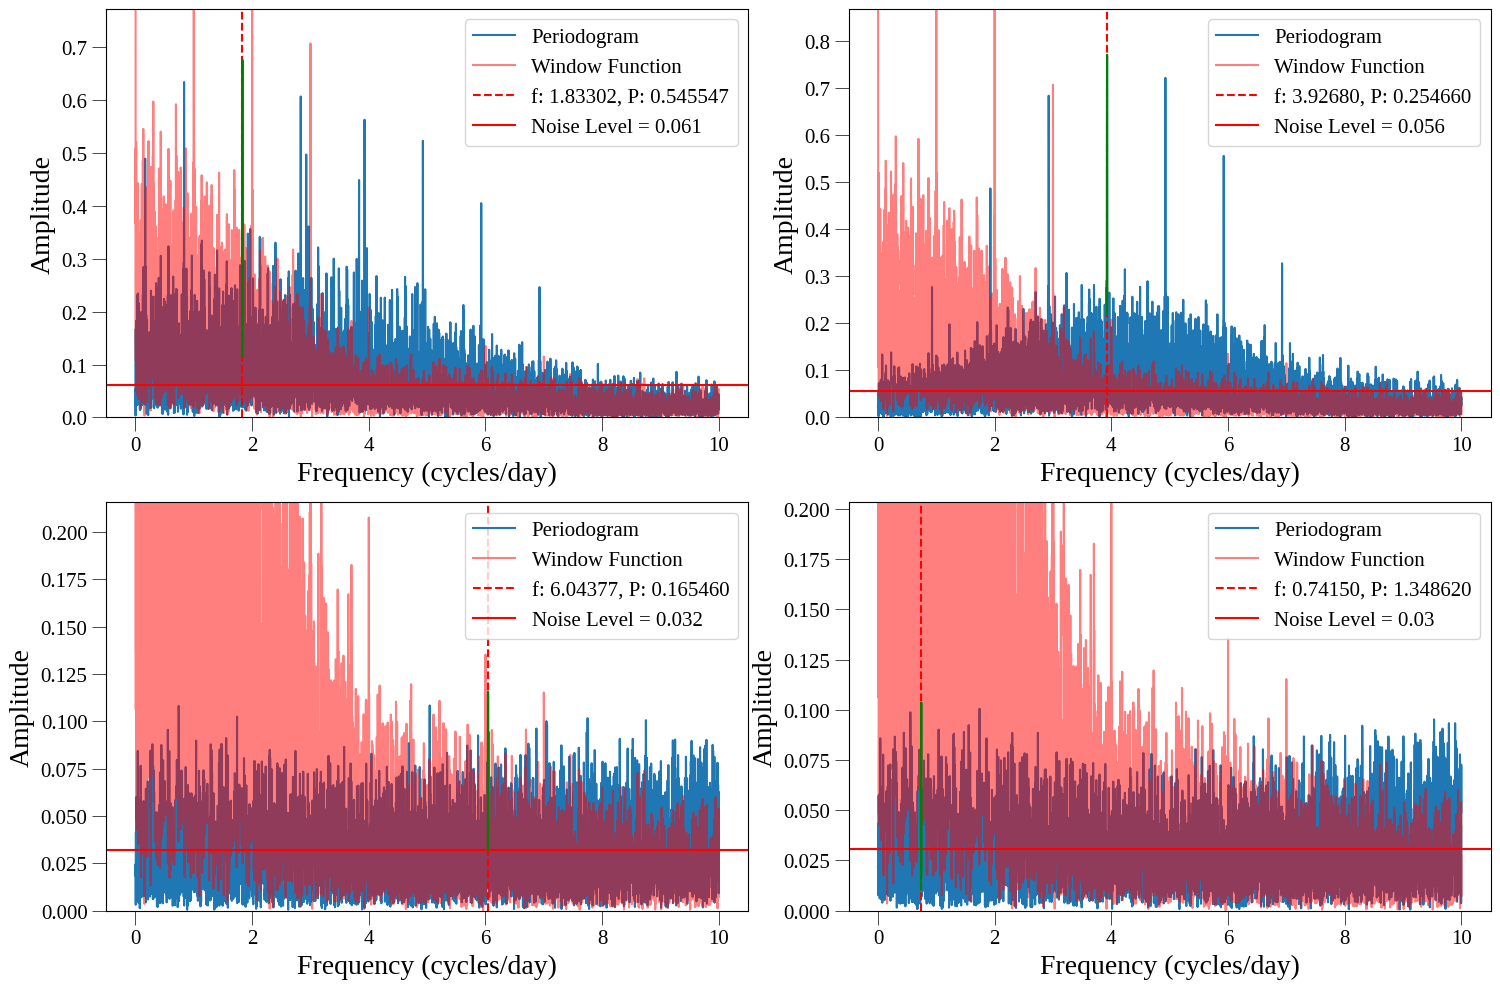

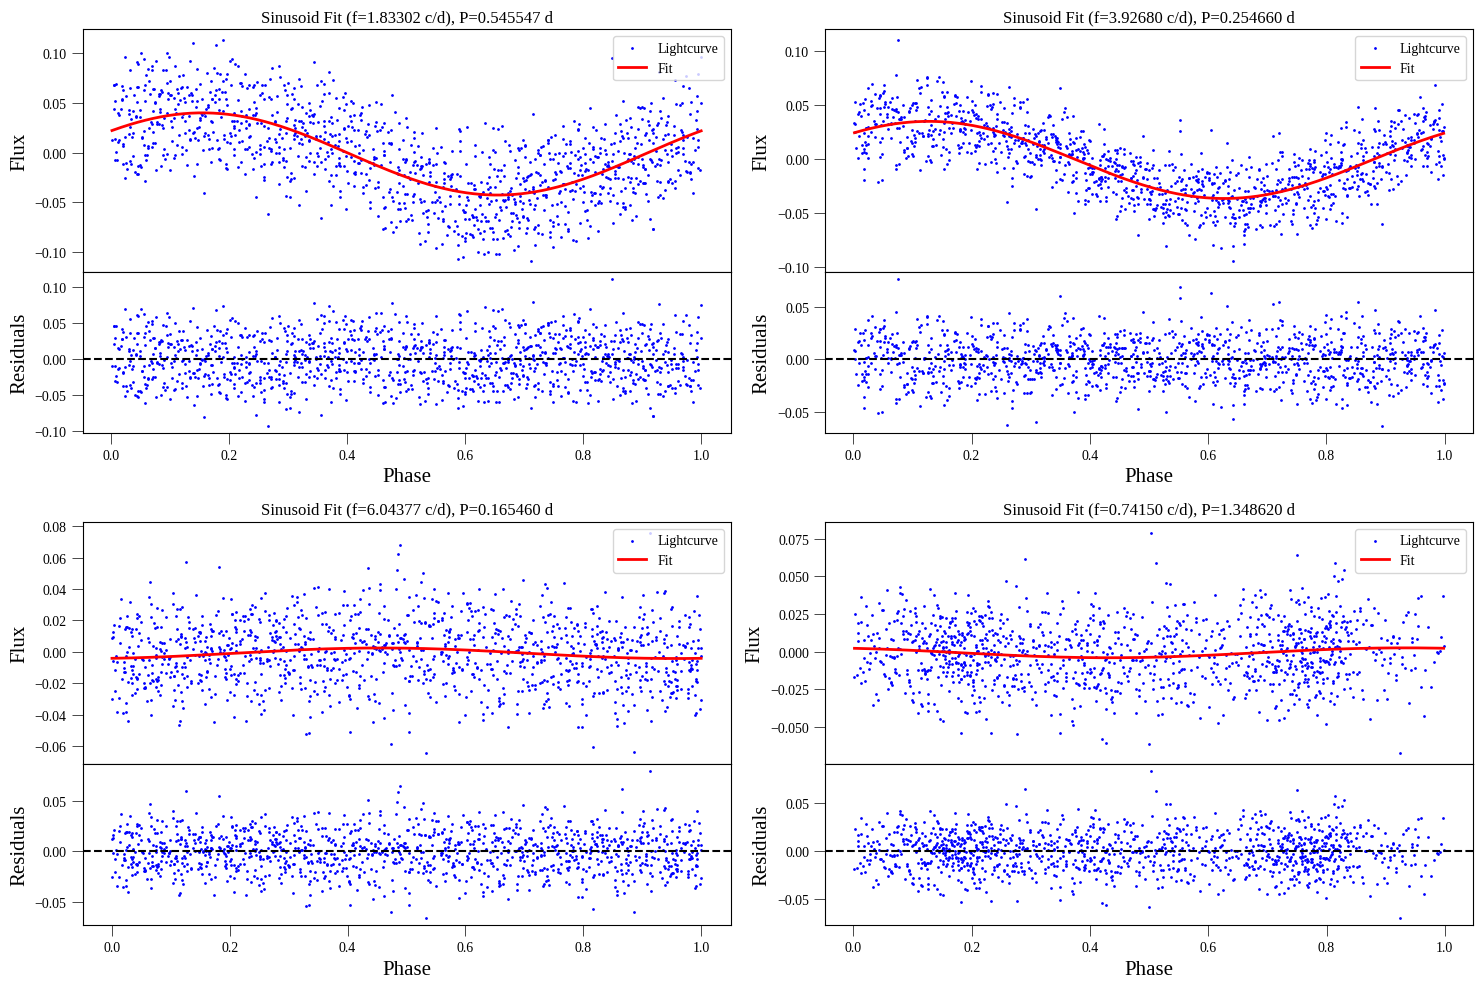

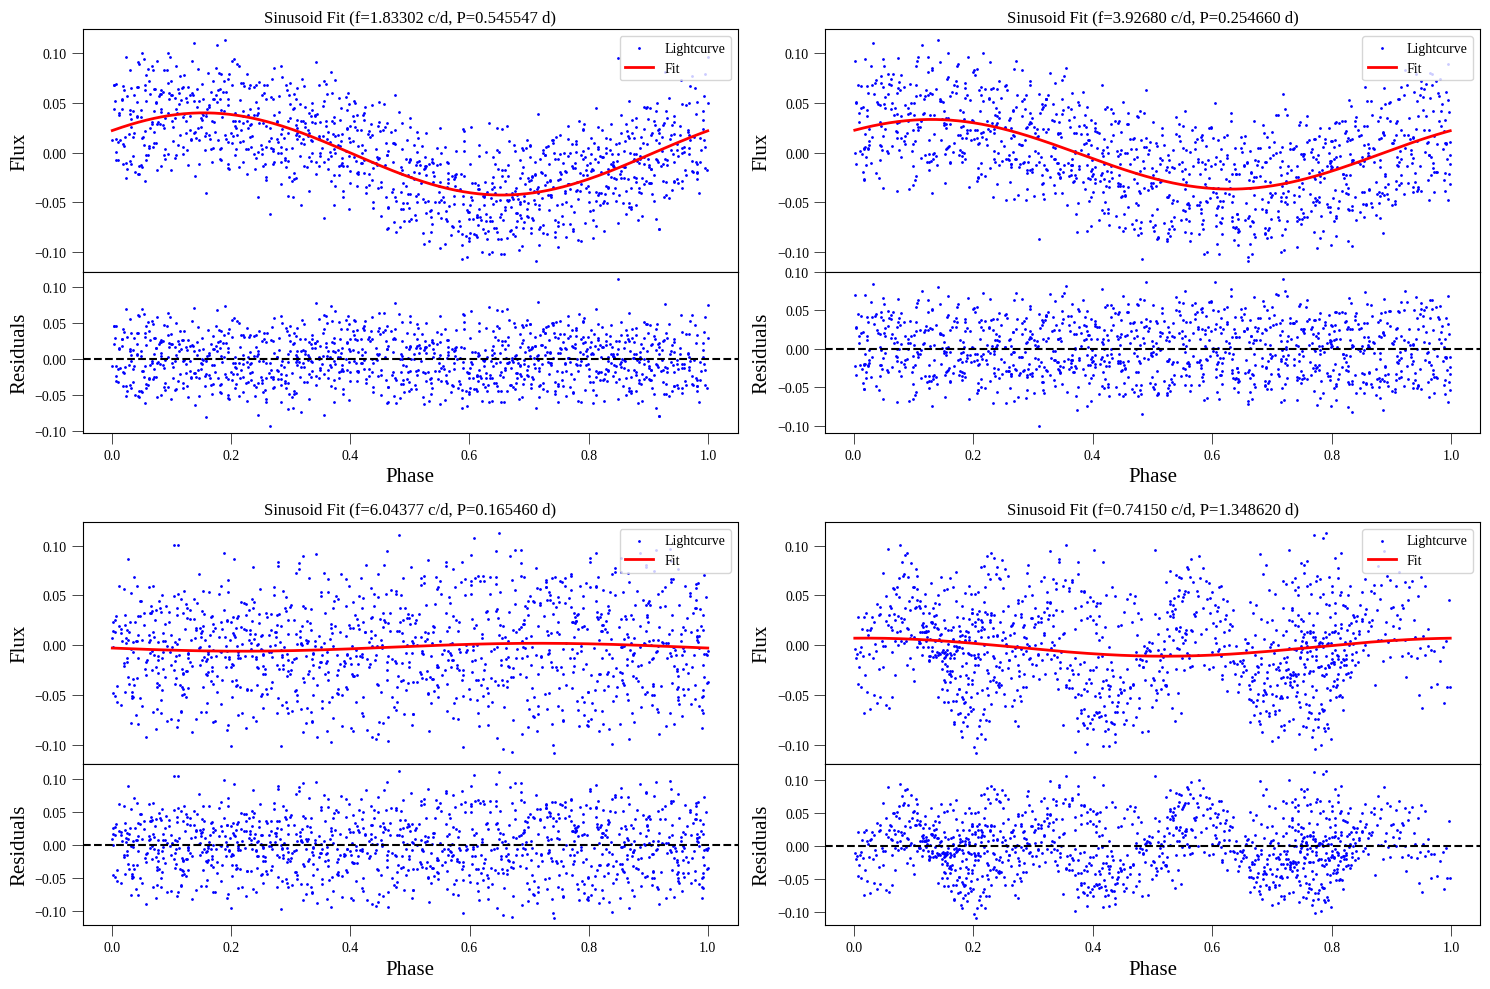

In [73]:
# # Periodogram for 4.dat
freq_4 = analyze_light_curve(4, max_frequencies=4, max_frequency=10)


Significant Frequencies:
Frequency: 7.62956+/-0.00002 c/d, Period: 0.131069+/-0.000000 d, Amplitude: 0.50520, SNR: 65.01, FAP: 1.46e-72
Frequency: 9.13811+/-0.00002 c/d, Period: 0.109432+/-0.000000 d, Amplitude: 0.47296, SNR: 59.37, FAP: 7.88e-62
Frequency: 7.83772+/-0.00002 c/d, Period: 0.127588+/-0.000000 d, Amplitude: 0.50527, SNR: 67.90, FAP: 1.38e-72
Frequency: 2.16349+/-0.00002 c/d, Period: 0.462217+/-0.000004 d, Amplitude: 0.53580, SNR: 125.72, FAP: 7.03e-84


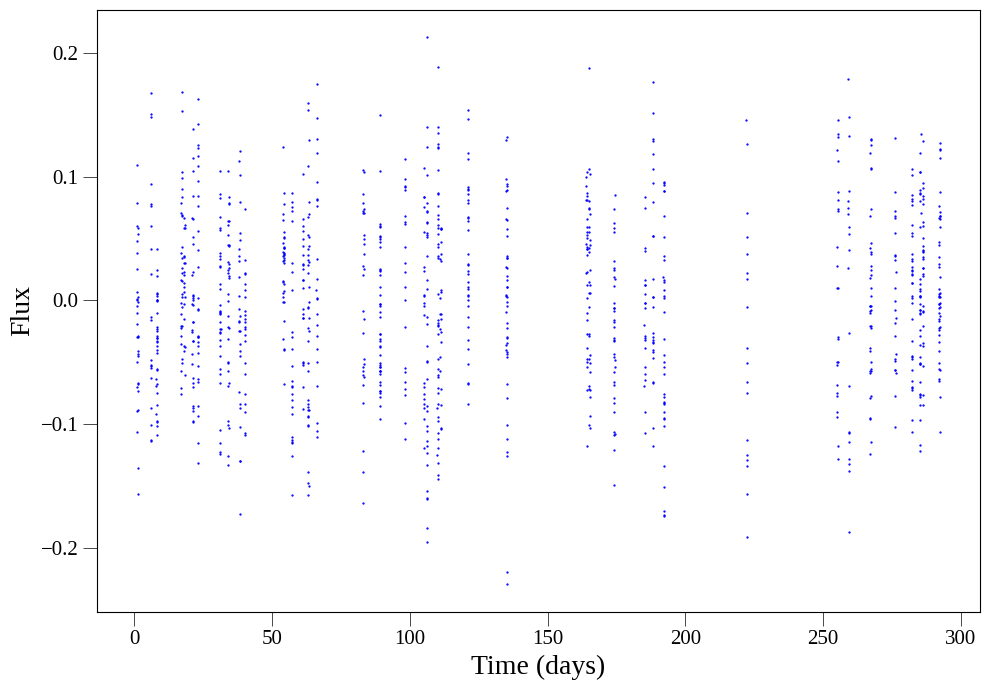

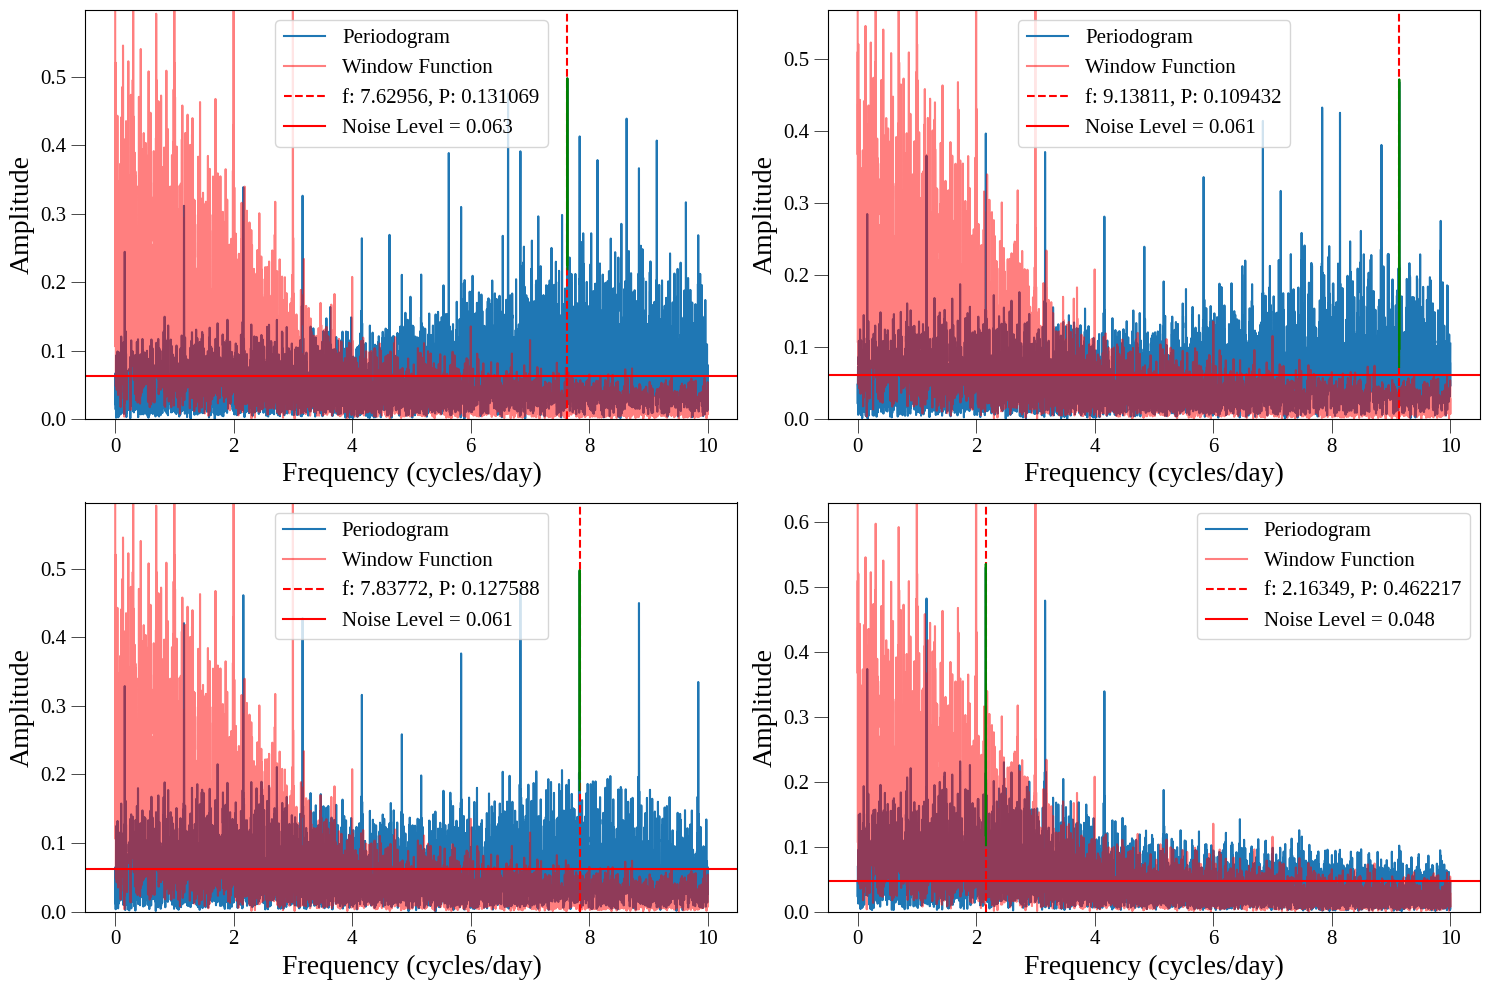

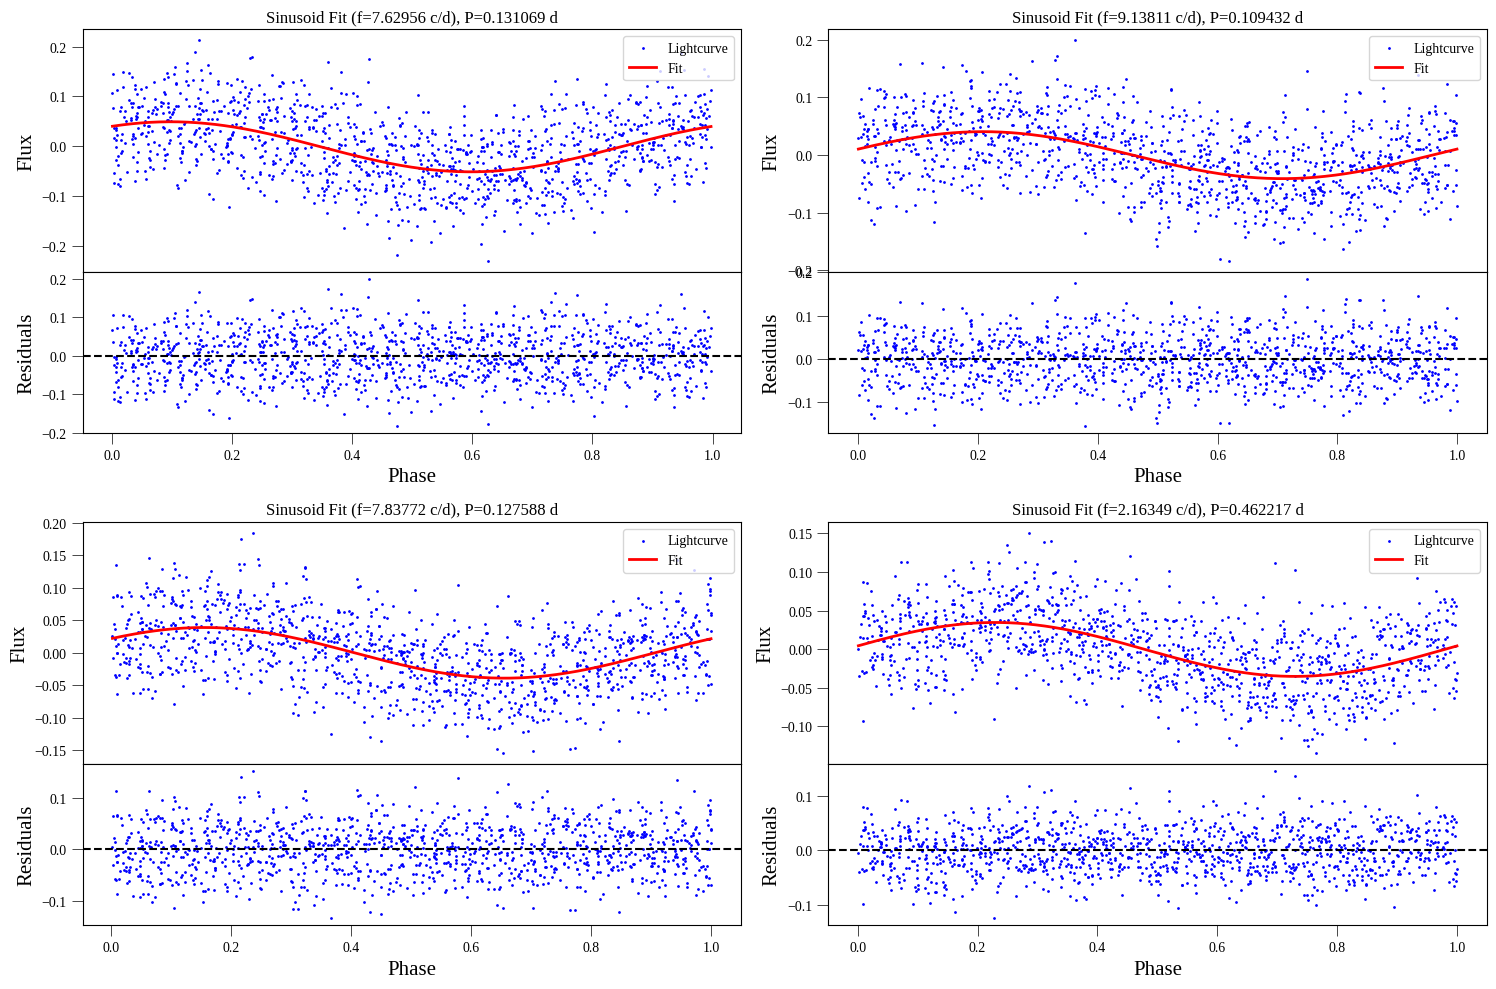

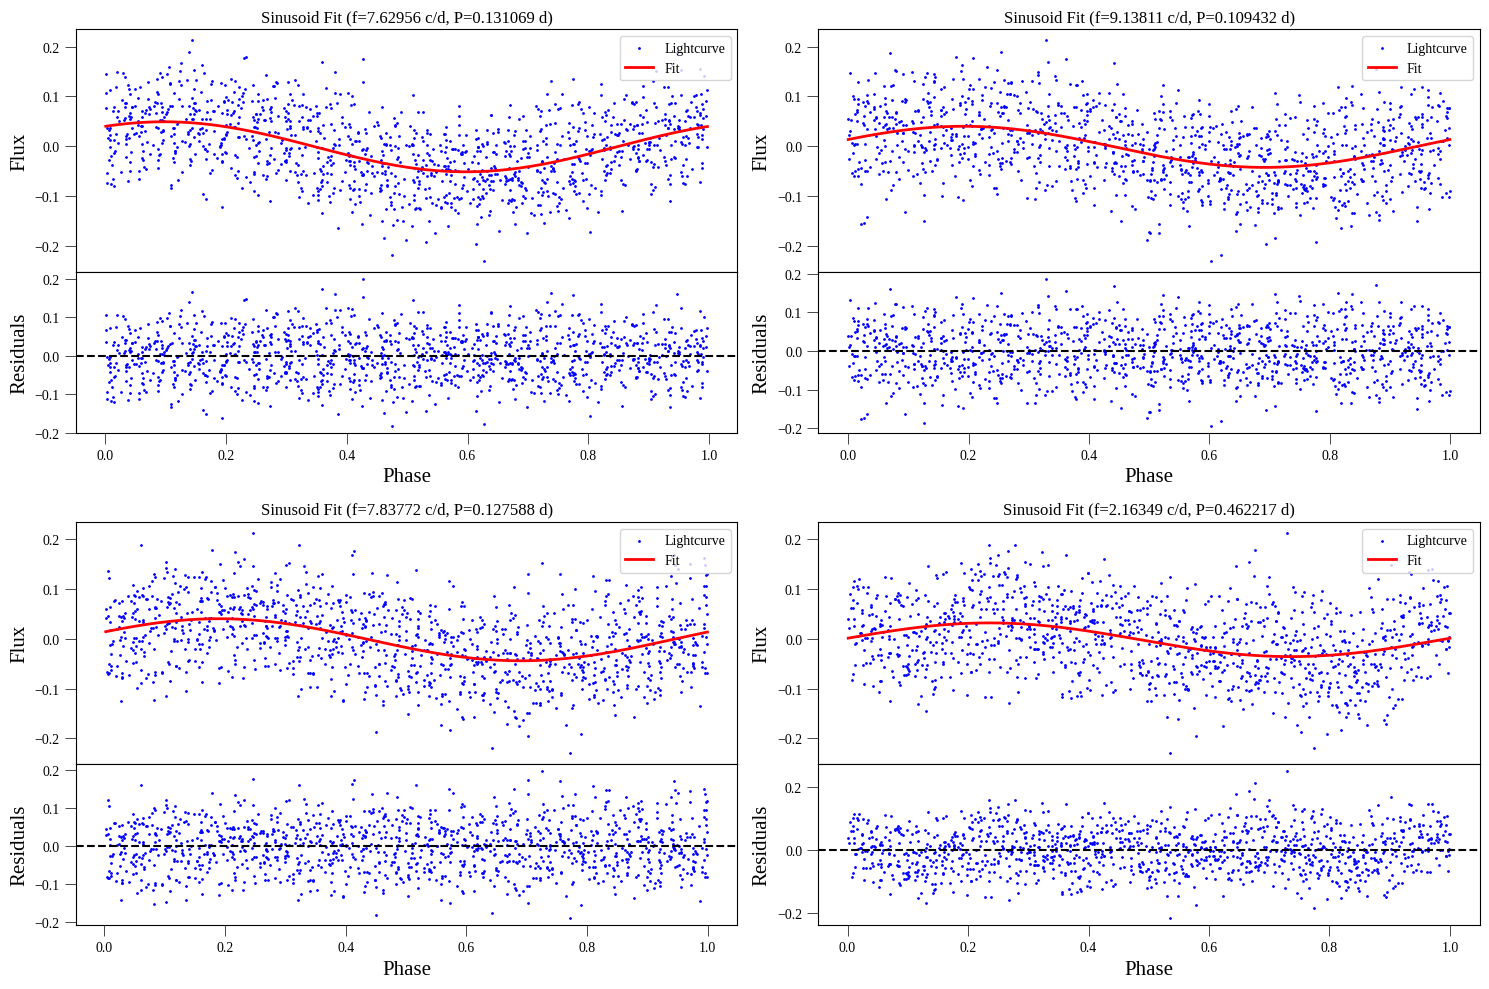

In [74]:
# # Periodogram for 5.dat
freq_5 = analyze_light_curve(5, max_frequencies=4, max_frequency=10)


Significant Frequencies:
Frequency: 1.75607+/-0.00004 c/d, Period: 0.569454+/-0.000014 d, Amplitude: 0.63111, SNR: 131.70, FAP: 8.06e-128
Frequency: 1.88514+/-0.00002 c/d, Period: 0.530464+/-0.000006 d, Amplitude: 0.57486, SNR: 103.35, FAP: 3.86e-100
Frequency: 4.55604+/-0.00001 c/d, Period: 0.219489+/-0.000001 d, Amplitude: 0.57333, SNR: 143.63, FAP: 1.85e-99
Frequency: 9.25930+/-0.00008 c/d, Period: 0.108000+/-0.000001 d, Amplitude: 0.13083, SNR: 15.29, FAP: 3.07e-01


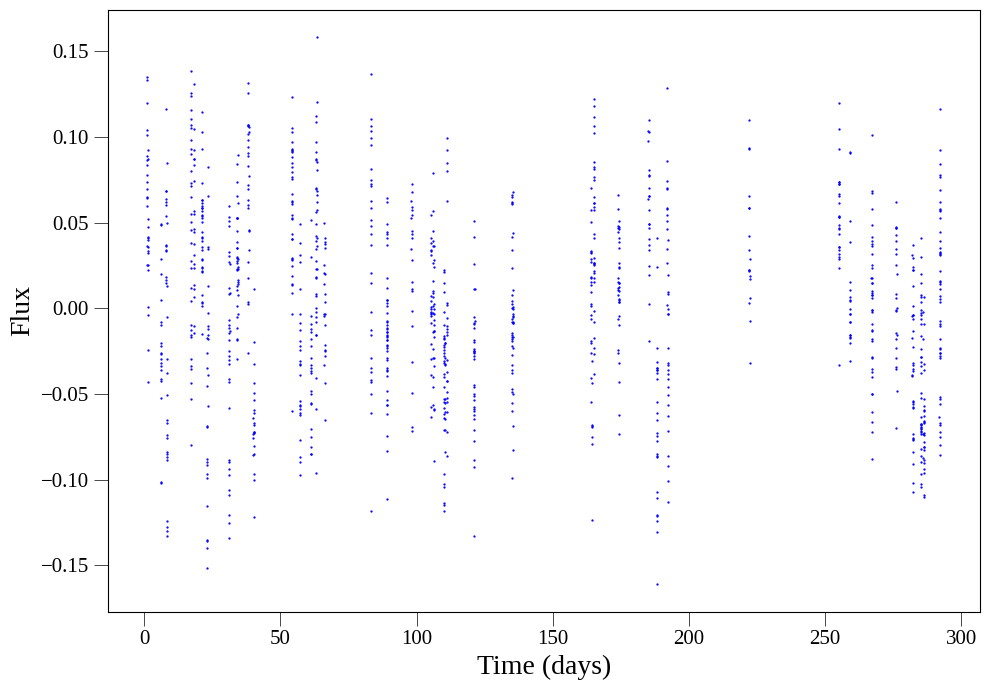

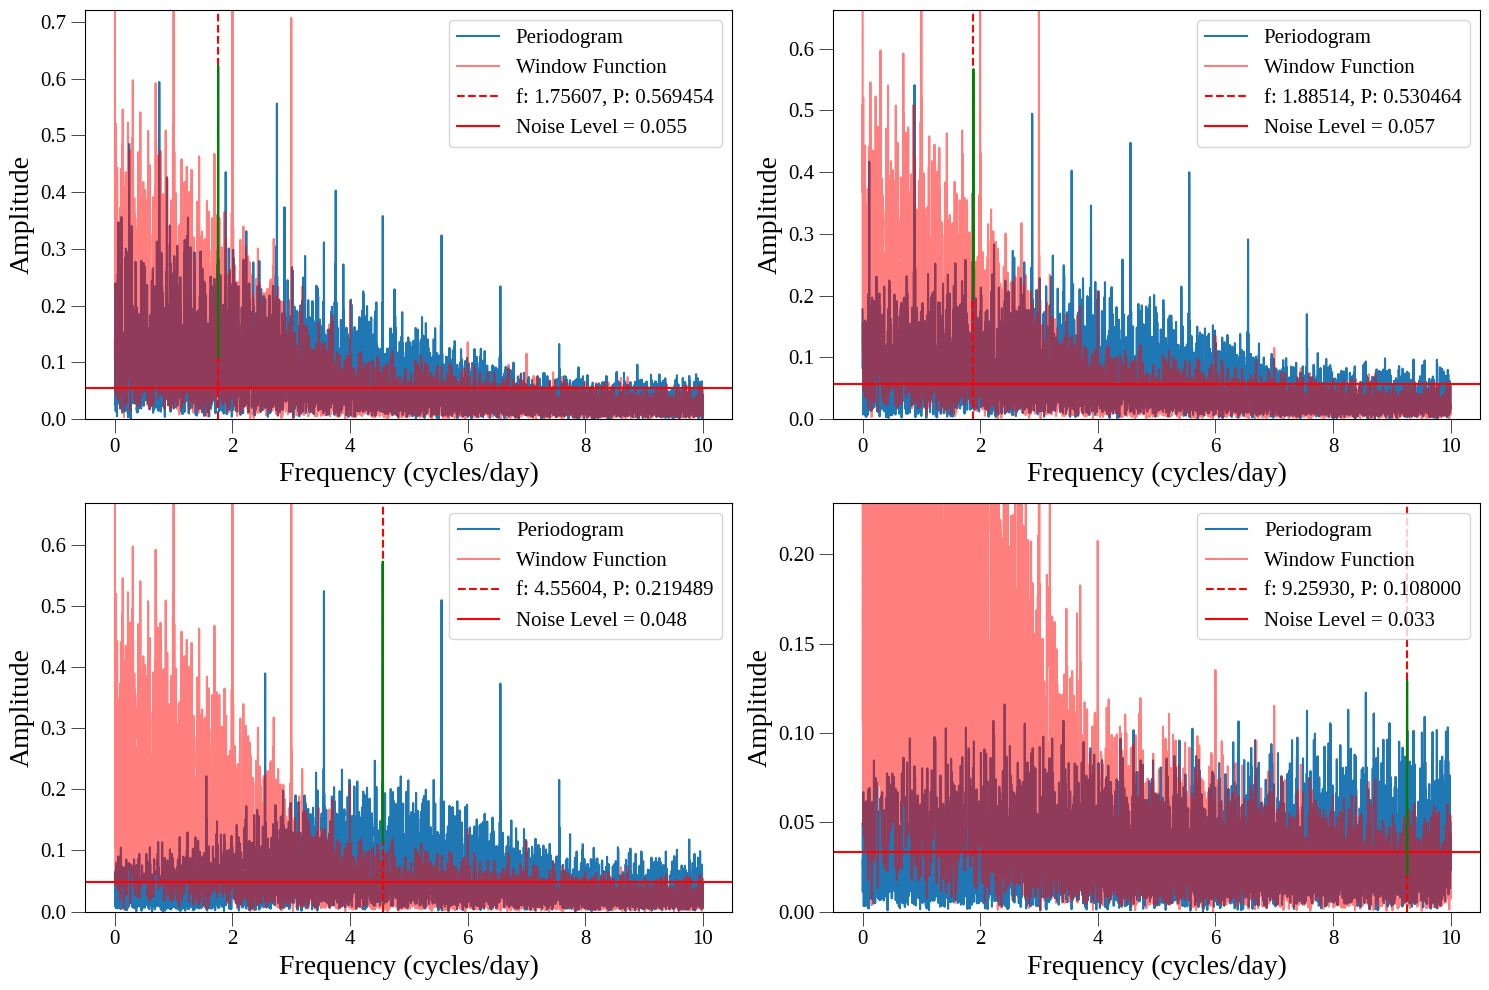

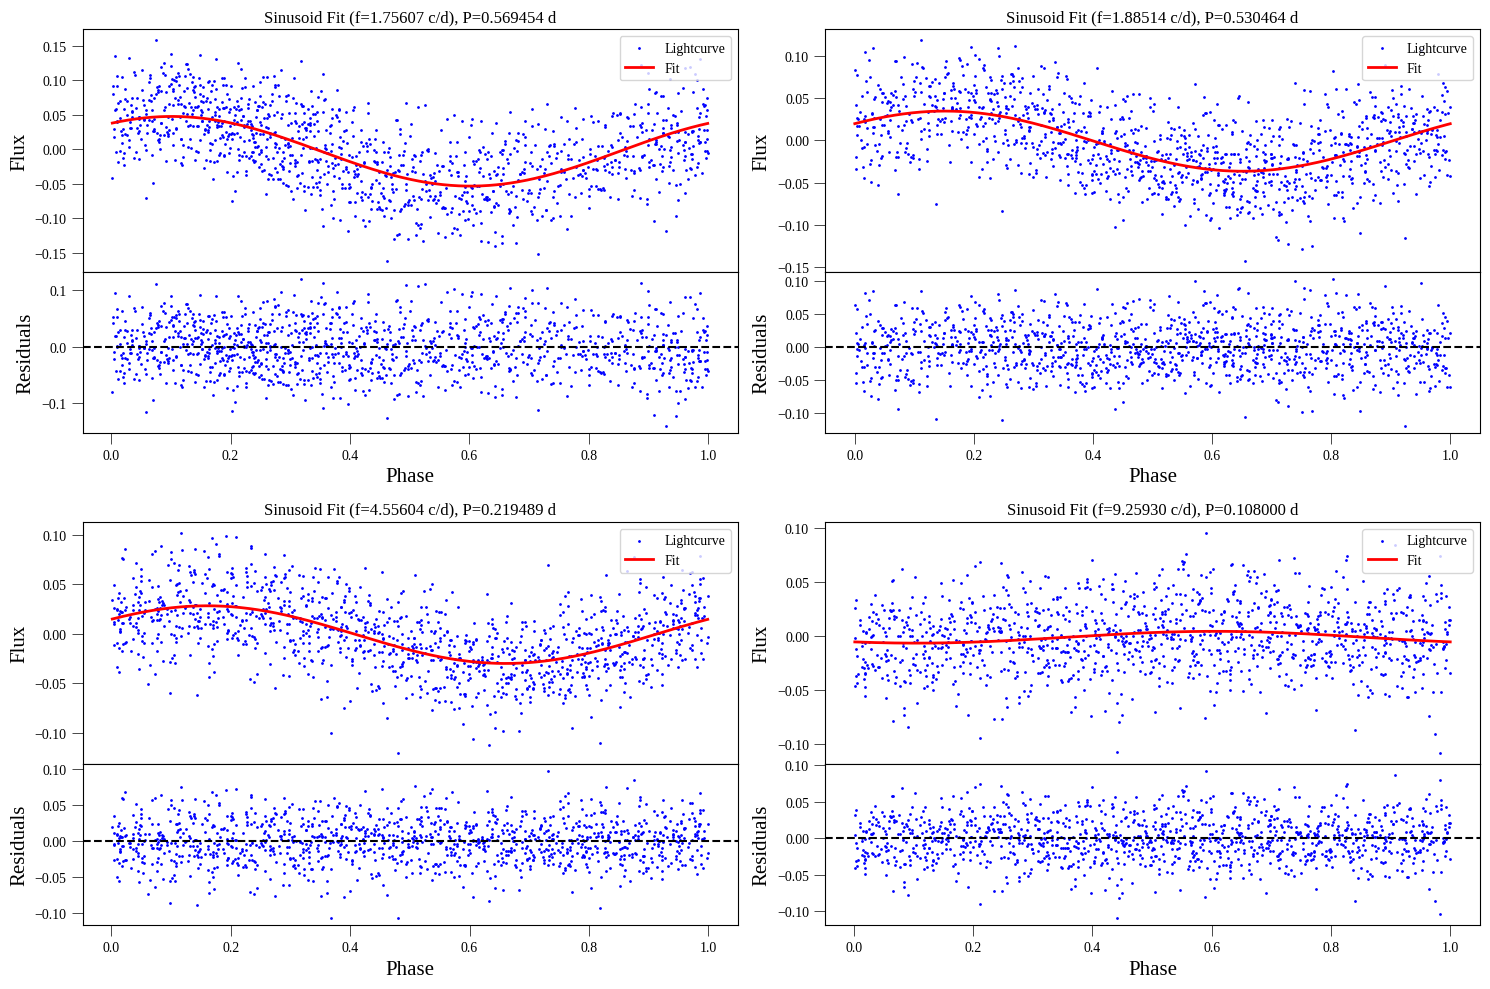

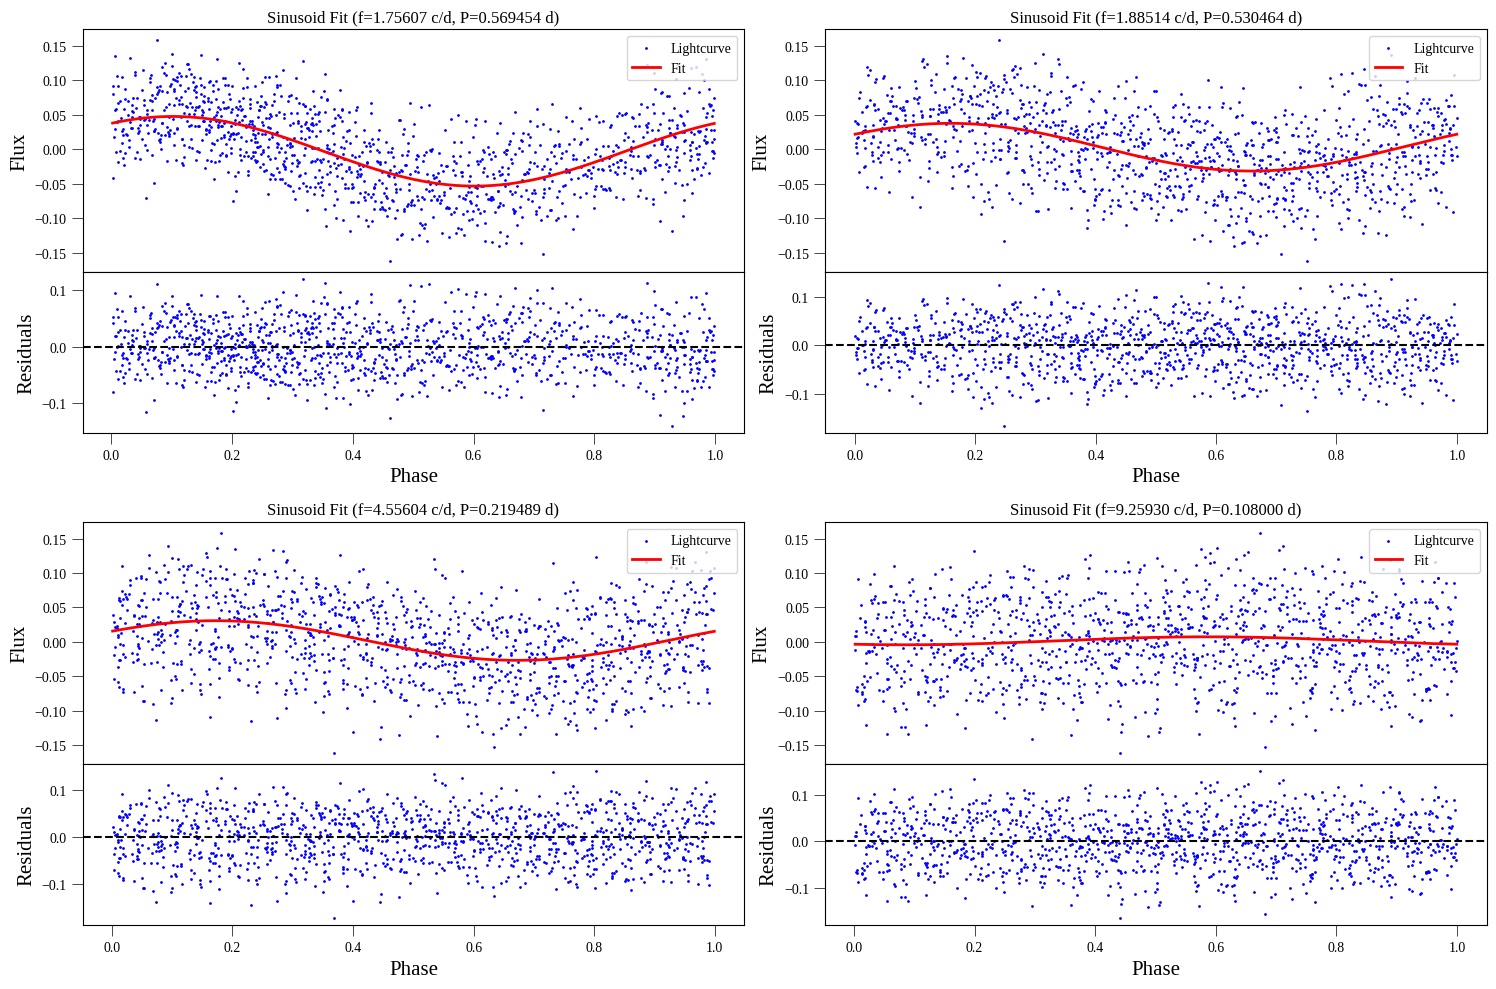

In [75]:
# Periodogram for 6.dat
freq_6 = analyze_light_curve(6, max_frequencies=4, max_frequency=10)